# **SAÉ 5.02 : Migration de données vers ou depuis un environnement NoSQL** 
## **Sujet : Intégration de données dans MongoDB (Olist)**
### *Date :  27/12/2024-04/01/2024*
### *Promo : BUT SD3*
### *Auteur : Julien RENOULT*

# Introduction sur le sujet

Cette SAE consiste dans un premier temps à insérer des données dans MongoDB et dans un deuxième temps, faire des requêtes de MongoDB pour de l'analyse exploratoire. Pour ce faire, nous allons dans cette notebook utiliser une librairie python (pymongo) pour créer notre connexion et nos bases de données pour ensuite insérer les différents fichiers de données.

# 1ère partie : importation et préparation des données

Dans cette partie, nous allons importer les données des fichiers CSV du site e-commerce [Olist](https://www.olist.com/) pour ensuite les préparer. Pour retrouver ce jeu de données et sa documentation, il a été mis à disposition sur [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

## Importation des données

In [113]:
# Chargement des librairies nécessaires à notre script
import pandas as pd
import numpy as np
from pymongo import MongoClient
import re
import os
import plotnine as plotn # Librairie pour les visualisations graphiques
import matplotlib.pyplot as plt

In [114]:
# Chemin menant vers le dossier contenant les différents fichiers CSV
chemin_fichs = "Data/projet_sd3/" # à modifier si nécessaire

In [115]:
# Création d'une fct utilitaire pour la création de tableaux graphiques
def create_table_plt(df):
        """
    Fonction :
    Création d'un tableau graphique avec mise en forme

    Arguments :
    - df : le dataframe à mettre sous forme de tableau
    
    Retour :
    Retour de l'objet de la table graphique
    """

        # Création de la figure
        fig, ax = plt.subplots(figsize=(5, 2))
        ax.axis('tight') # Pour enlever les axes
        ax.axis('off')

        # Création du tableau
        table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

        # Personnalisation des styles
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # En-tête des colonnes
                cell.set_fontsize(12)
                cell.set_text_props(weight='bold', color='white')  # Texte en gras et blanc
                cell.set_facecolor('black')  # Fond noir
            else:  # Contenu des cellules
                cell.set_fontsize(10)

        return table

#### Commentaires : 
Pour importer et préparer nos données, nous allons utiliser la librairie *pandas* mais aussi *os* et *re* pour ne prendre en compte que les fichiers qui nous intéressent.

In [116]:
# Regardons le contenu de notre dossier qui nous est indiqué dans "chemin_fichs"
liste_fich = os.listdir(chemin_fichs)
liste_fich

['olist_customers_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

#### Commentaires :
Dans les fichiers qui nous ont été transmis, celles qui nous intéressent sont ceux commençant par "olist". Pour éviter d'importer des données non nécessaires, nous allons utiliser la librairie re pour identifier celles qui doivent être importées.

In [117]:
# Création d'une variable dict_olist contenant nos différents dataframes créés avec leur appelation (par exemple : "olist_customers_dataset")
dict_olist = {}

# Parcours de chaque dataframe et l'insérer dans le dictionnaire
for fich in liste_fich:
    if re.match("^olist", fich) != None :

        # Lecture du fichier de données
        df = pd.read_csv(chemin_fichs + fich, 
                    sep=",", header=0,
                    decimal=".")
        
        # Ajout dans le dictionnaire avec le nom du fichier comme clé
        nom_cle = re.split("\\.", fich)[0]
        dict_olist[nom_cle] = df


In [118]:
print(dict_olist.keys()) # Observation des différents nom de dataframes

dict_keys(['olist_customers_dataset', 'olist_orders_dataset', 'olist_order_items_dataset', 'olist_order_payments_dataset', 'olist_order_reviews_dataset', 'olist_products_dataset', 'olist_sellers_dataset'])


#### Commentaire :

On peut observer qui nous a bien importé ceux qui respectent le pattern indiqué. Observons maintenant leurs données.

## Prise en compte de la structure des dataframes

Observons maintenant nos jeux de données et voir s'il y a des transformations/vérifications à faire.

In [119]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[0:3]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].head(20))
    print("----------------------------------\n")

---- Pour le fichier olist_customers_dataset ---- 
                         customer_id                customer_unique_id  \
0   06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1   18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2   4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3   b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4   4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
5   879864dab9bc3047522c92c82e1212b8  4c93744516667ad3b8f1fb645a3116a4   
6   fd826e7cf63160e536e0908c76c3f441  addec96d2e059c80c30fe6871d30d177   
7   5e274e7a0c3809e14aba7ad5aae0d407  57b2a98a409812fe9618067b6b8ebe4f   
8   5adf08e34b2e993982a47070956c5c65  1175e95fb47ddff9de6b2b06188f7e0d   
9   4b7139f34592b3a31687243a302fa75b  9afe194fb833f79e300e37e580171f22   
10  9fb35e4ed6f0a14a4977cd9aea4042bb  2a7745e1ed516b289ed9b29c7d0539a5   
11  5aa9e4fdd4dfd20959cad2d772509598  2a46fb94aef5cbeeb850418

In [120]:
dict_olist["olist_order_items_dataset"]["order_item_id"].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

In [121]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[3:]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].head(2))
    print("----------------------------------\n")

---- Pour le fichier olist_order_payments_dataset ---- 
                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
----------------------------------

---- Pour le fichier olist_order_reviews_dataset ---- 
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  20

#### Commentaire :
On peut observer pour le dataframe *olist_oreder_reviews_dataset* qu'il y a la présence de données manquantes, il faudra donc faire attention à ceci lors de la préparation des données.

In [122]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[6:]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].head(1))
    print("----------------------------------\n")

---- Pour le fichier olist_sellers_dataset ---- 
                          seller_id  seller_zip_code_prefix seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023    campinas   

  seller_state  
0           SP  
----------------------------------



Observons la dimension de nos différents dataframes

In [123]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys()):
    print("---- Pour le fichier "+key+" ---- ")
    print("Lignes : {} Colonnes : {}".format(dict_olist[key].shape[0], dict_olist[key].shape[1]))
    print("----------------------------------\n")

---- Pour le fichier olist_customers_dataset ---- 
Lignes : 99441 Colonnes : 5
----------------------------------

---- Pour le fichier olist_orders_dataset ---- 
Lignes : 99441 Colonnes : 8
----------------------------------

---- Pour le fichier olist_order_items_dataset ---- 
Lignes : 112650 Colonnes : 7
----------------------------------

---- Pour le fichier olist_order_payments_dataset ---- 
Lignes : 103886 Colonnes : 5
----------------------------------

---- Pour le fichier olist_order_reviews_dataset ---- 
Lignes : 99224 Colonnes : 7
----------------------------------

---- Pour le fichier olist_products_dataset ---- 
Lignes : 32951 Colonnes : 9
----------------------------------

---- Pour le fichier olist_sellers_dataset ---- 
Lignes : 3095 Colonnes : 4
----------------------------------



Observons maintenant leurs colonnes et types

In [124]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[0:2]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].dtypes)
    print("----------------------------------\n")

---- Pour le fichier olist_customers_dataset ---- 
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
----------------------------------

---- Pour le fichier olist_orders_dataset ---- 
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
----------------------------------



### Explication des colonnes 

En observant ces deux dataframes, on observe que le premier concerne les clients avec comme colonne :
- customer_id : identifiant du client
- customer_unique_id : identifiant unique du client
- customer_zip_code_prefix : 5 premiers chiffres du code postal du client
- customer_city : ville du client
- customer_state : état où se trouve la ville (code de deux caractères)

Le deuxième concerne les commandes faites par le client :
- order_id : identifiant de la commande
- customer_id : identifiant du client
- order_status : statut de la commande
- order_purchase_timestamp : la date d'achat
- order_approved_at : la date d'approbation du paiement de la commande
- order_delivered_carrier_date : la date à laquelle la commande a été transmise au partenaire logistique.
- order_delivered_customer_date : la date factuelle à laquelle la commande est arrivée chez le client
- order_estimated_delivery_date : la date estimée à laquelle la commande arrive chez le client


In [125]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[2:4]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].dtypes)
    print("----------------------------------\n")

---- Pour le fichier olist_order_items_dataset ---- 
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
----------------------------------

---- Pour le fichier olist_order_payments_dataset ---- 
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object
----------------------------------



In [126]:
dict_olist["olist_order_payments_dataset"]["payment_sequential"].value_counts()

payment_sequential
1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
17        6
19        6
18        6
16        6
20        4
21        4
22        3
24        2
25        2
26        2
23        2
27        1
28        1
29        1
Name: count, dtype: int64

In [127]:
dict_olist["olist_order_payments_dataset"]["payment_type"].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [128]:
dict_olist["olist_order_payments_dataset"]["payment_value"].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

### Explication des colonnes

En observant ces deux dataframes, on observe que le premier concerne ce que contient chaque commande avec chaque item :
- order_id : identifiant de la commande
- order_item_id : l'ordre du produit auquel il a été commandé (1 : 1ère article)
- product_id : identifiant du produit
- seller_id : identifiant du vendeur
- shipping_limit_date : date limite d'expédition
- price : prix au total de ce produit
- freight_value : prix du transport du produit (si une commande comporte plus d'un produit, la valeur du fret est répartie entre les produits)

Le deuxième concerne le paiement effectué sur la commande en question :
- order_id : identifiant de la commande
- payment_sequential : nombre de paiement effectué pour payer la commande
- payment_type : type de paiement
- payment_value : montant du paiement à effectuer

In [129]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[4:6]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].dtypes)
    print("----------------------------------\n")

---- Pour le fichier olist_order_reviews_dataset ---- 
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object
----------------------------------

---- Pour le fichier olist_products_dataset ---- 
product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object
----------------------------------



In [130]:
dict_olist["olist_order_reviews_dataset"][["review_answer_timestamp", "review_creation_date"]]

review_answer_timestamp review_creation_date
0         2018-01-18 21:46:59  2018-01-18 00:00:00
1         2018-03-11 03:05:13  2018-03-10 00:00:00
2         2018-02-18 14:36:24  2018-02-17 00:00:00
3         2017-04-21 22:02:06  2017-04-21 00:00:00
4         2018-03-02 10:26:53  2018-03-01 00:00:00
...                       ...                  ...
99219     2018-07-14 17:18:30  2018-07-07 00:00:00
99220     2017-12-11 20:06:42  2017-12-09 00:00:00
99221     2018-03-23 09:10:43  2018-03-22 00:00:00
99222     2018-07-02 12:59:13  2018-07-01 00:00:00
99223     2017-07-03 21:01:49  2017-07-03 00:00:00

[99224 rows x 2 columns]

### Explication des colonnes

En observant ces deux dataframes, on observe que le premier concerne les notes et reviews des clients par une enquête de satisfaction avec comme colonne :
- review_id : identifiant du review
- order_id : identifiant de la commande
- review_score : note de 1 à 5 donnée par le client lors d'une enquête de satisfaction.
- review_comment_title : titre du commentaire
- review_comment_message : commentaire du client au sujet des livraisons
- review_creation_date  : date d'envoie de l'enquête de satisfaction
- review_answer_timestamp : date de réponse du client sur l'enquête de satisfaction

Le deuxième concerne les produits et leurs descriptions :
- produt_id : identifiant du produit
- product_category_name : catégorie du produit
- product_name_length : longueur du nom du produit
- product_description_length : longueur de la description du produit
- product_photos_qty : nombre de photos disponibles concernant le produit
- product_weight_g : poids du produit en grammes
- product_length_cm : la longueur du produit en centimètre
- product_height_cm : la taille du produit en centimètre
- product_width_cm : la largeur du produit en centimètre

In [131]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[6:]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].dtypes)
    print("----------------------------------\n")

---- Pour le fichier olist_sellers_dataset ---- 
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object
----------------------------------



### Explication des colonnes

En observant ces deux dataframes, on observe que le premier concerne les clients avec comme colonne :
- seller_id : identifiant du vendeur
- seller_zip_code_prefix : 5 premiers chiffres du code postal du vendeur
- seller_city : ville du vendeur
- seller_state : état où se trouve la ville (code de deux caractères)


#### Commentaires :

Tous les dataframes semblent avoir le bon type pour chacune des colonnes à l'exception de ceux concernant les dates dont il faut faire la conversion (format : yy-mm-dd HH:MM:SS).
Les dataframes et les colonnes concernés sont :
- olist_order_reviews_dataset (review_answer_timestamp,review_creation_date)
- olist_order_items_dataset (shipping_limit_date)
- olist_orders_dataset (order_delivered_carrier_date, order_purchase_timestamp, order_approved_at, 
                        order_delivered_customer_date, order_estimated_delivery_date)

In [132]:
# Vérifier s'il n'y a pas de doublons
for key in list(dict_olist.keys()):

    # Regardons la présence de doublons
    mask = dict_olist[key].duplicated()

    print("---- Pour le fichier "+key+" ---- ")
    print("Présence de doublons : ", mask.any())
    if mask.any():
        print(dict_olist[key].loc[mask, :].head(10))
    print("----------------------------------\n")


---- Pour le fichier olist_customers_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_orders_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_order_items_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_order_payments_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_order_reviews_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_products_dataset ---- 
Présence de doublons :  False
----------------------------------

---- Pour le fichier olist_sellers_dataset ---- 
Présence de doublons :  False
----------------------------------



#### Commentaire :

On a pas de doublons dans nos jeu de données ce qui rends plus facile la préparation des données.

## Conversion en date des colonnes concernées + conversion en entier

In [133]:
pd.to_datetime(dict_olist["olist_order_reviews_dataset"]["review_answer_timestamp"],
               format='%Y-%m-%d %H:%M:%S')

0       2018-01-18 21:46:59
1       2018-03-11 03:05:13
2       2018-02-18 14:36:24
3       2017-04-21 22:02:06
4       2018-03-02 10:26:53
                ...        
99219   2018-07-14 17:18:30
99220   2017-12-11 20:06:42
99221   2018-03-23 09:10:43
99222   2018-07-02 12:59:13
99223   2017-07-03 21:01:49
Name: review_answer_timestamp, Length: 99224, dtype: datetime64[ns]

In [134]:
# Création d'une fct utilitaire sur la conversion de dates d'un ou plusieurs colonnes
def df_to_datetime(df, cols_conc, format='%Y-%m-%d %H:%M:%S'):
    """
    Permet de convertir une ou plusieurs colonnes d'un dataframe en datetime avec le format spécifié.
    Arguments :
    - df : le dataframe concerné
    - cols_conc : liste des colonnes concernées
    - format : le format à utiliser lors de la conversion (par défaut : '%Y-%m-%d %H:%M:%S')
    Retour : 
    retour du DataFrame avec les colonnes concernées converties en datetime.
    """

    for col in cols_conc:
        df[col] = pd.to_datetime(df[col], format=format)
    
    return df


In [135]:
# Application sur les dataframes concernés
dict_olist["olist_order_reviews_dataset"] = df_to_datetime(dict_olist["olist_order_reviews_dataset"], ["review_answer_timestamp", "review_creation_date"])
dict_olist["olist_order_items_dataset"] = df_to_datetime(dict_olist["olist_order_items_dataset"], ["shipping_limit_date"])
dict_olist["olist_orders_dataset"] = df_to_datetime(dict_olist["olist_orders_dataset"], [
                        "order_delivered_carrier_date", "order_purchase_timestamp", "order_approved_at", 
                        "order_delivered_customer_date", "order_estimated_delivery_date"])

In [136]:
dict_olist["olist_orders_dataset"].dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [137]:
dict_olist["olist_products_dataset"][["product_description_lenght", 
                                      "product_name_lenght", "product_photos_qty"]]

product_description_lenght  product_name_lenght  product_photos_qty
0                           287.0                 40.0                 1.0
1                           276.0                 44.0                 1.0
2                           250.0                 46.0                 1.0
3                           261.0                 27.0                 1.0
4                           402.0                 37.0                 4.0
...                           ...                  ...                 ...
32946                        67.0                 45.0                 2.0
32947                       971.0                 41.0                 1.0
32948                       799.0                 50.0                 1.0
32949                       156.0                 60.0                 2.0
32950                       309.0                 58.0                 1.0

[32951 rows x 3 columns]

In [138]:
# Conversion en entier
dict_olist["olist_products_dataset"][["product_description_lenght", 
                                      "product_name_lenght", "product_photos_qty"]] = dict_olist["olist_products_dataset"][["product_description_lenght", 
                                                                                                                                    "product_name_lenght",
                                                                                                                                    "product_photos_qty"]].astype("Int64")
dict_olist["olist_products_dataset"][["product_description_lenght", 
                                      "product_name_lenght", "product_photos_qty"]]

product_description_lenght  product_name_lenght  product_photos_qty
0                             287                   40                   1
1                             276                   44                   1
2                             250                   46                   1
3                             261                   27                   1
4                             402                   37                   4
...                           ...                  ...                 ...
32946                          67                   45                   2
32947                         971                   41                   1
32948                         799                   50                   1
32949                         156                   60                   2
32950                         309                   58                   1

[32951 rows x 3 columns]

In [139]:
# Vérification du succès de l'opération
dict_olist["olist_products_dataset"].dtypes

product_id                     object
product_category_name          object
product_name_lenght             Int64
product_description_lenght      Int64
product_photos_qty              Int64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

## Observer les données manquantes de chaque dataframe

Maintenant que nous avons convertie tous du bon type, nous allons maintenant observer la présence de données manquantes dans nos différents dataframes.

 ---- Pour le dataframe olist_orders_dataset ---- 
order_id                         0.00
customer_id                      0.00
order_status                     0.00
order_purchase_timestamp         0.00
order_approved_at                0.16
order_delivered_carrier_date     1.79
order_delivered_customer_date    2.98
order_estimated_delivery_date    0.00
dtype: float64
--------------------------------------

 ---- Pour le dataframe olist_order_reviews_dataset ---- 
review_id                   0.00
order_id                    0.00
review_score                0.00
review_comment_title       88.34
review_comment_message     58.70
review_creation_date        0.00
review_answer_timestamp     0.00
dtype: float64
--------------------------------------

 ---- Pour le dataframe olist_products_dataset ---- 
product_id                    0.00
product_category_name         1.85
product_name_lenght           1.85
product_description_lenght    1.85
product_photos_qty            1.85
product_weight_g  

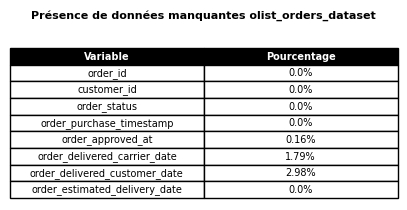

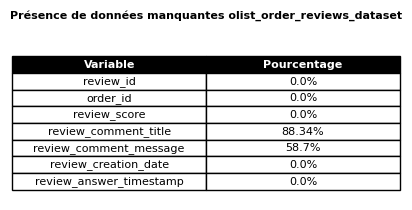

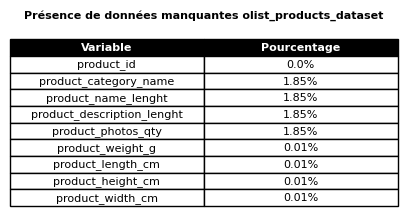

In [140]:
# Observation des dataframes contenant des valeurs manquantes (>0%)
for key in dict_olist:
    percent_nan = round((dict_olist[key].isna().sum() / len(dict_olist[key])) * 100, 2)

    if percent_nan.sum() > 0 :
        print(" ---- Pour le dataframe "+key+" ---- ")
        print(percent_nan)
        print("--------------------------------------\n")

        # Enregistrer le tableau dans Images_explo
        # Transformation en DataFrame
        data = pd.DataFrame({"Variable" : percent_nan.index, "Pourcentage" : percent_nan.values})

        data["Pourcentage"] = data["Pourcentage"].map(lambda x: str(x)+"%")

        table = create_table_plt(data)

        # Ajout d'un titre
        plt.title('Présence de données manquantes '+key, fontsize=8, pad=20, weight="bold")

        # Sauvegarde en image
        plt.savefig("Images_explo/tableau_{}.png".format(key), bbox_inches='tight', dpi=300)


In [141]:
(dict_olist["olist_products_dataset"].isna().sum() / len(dict_olist["olist_products_dataset"])) * 100

product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

#### Commentaires 

On peut observer que trois dataframes possèdent des données manquantes notamment pour les colonnes "review_comment_title" et "review_comment_message" du dataframe "olist_order_reviews_dataset" avec respectivement environ 88% et 59% de données manquantes. Pour les autres dataframes, la présence de données manquantes est très faible (entre 0 et 3%) ce qui engage à vérifier du pourquoi et du comment ces données sont manquantes.

### Pour le dataframe concernant les produits

In [142]:
# Regardons pour olist_products_dataset les observations manquantes
dataframe_products_missing = dict_olist["olist_products_dataset"][dict_olist["olist_products_dataset"].isna().any(axis=1)]

In [143]:
# Vérification du succès de l'opération
dataframe_products_missing

product_id product_category_name  \
105    a41e356c76fab66334f36de622ecbd3a                   NaN   
128    d8dee61c2034d6d075997acef1870e9b                   NaN   
145    56139431d72cd51f19eb9f7dae4d1617                   NaN   
154    46b48281eb6d663ced748f324108c733                   NaN   
197    5fb61f482620cb672f5e586bb132eae9                   NaN   
...                                 ...                   ...   
32515  b0a0c5dd78e644373b199380612c350a                   NaN   
32589  10dbe0fbaa2c505123c17fdc34a63c56                   NaN   
32616  bd2ada37b58ae94cc838b9c0569fecd8                   NaN   
32772  fa51e914046aab32764c41356b9d4ea4                   NaN   
32852  c4ceee876c82b8328e9c293fa0e1989b                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
105                   <NA>                        <NA>                <NA>   
128                   <NA>                        <NA>                <NA>   
145                   <NA>                        <NA>                <NA>   
154                   <NA>                        <NA>                <NA>   
197                   <NA>                        <NA>                <NA>   
...                    ...                         ...                 ...   
32515                 <NA>                        <NA>                <NA>   
32589                 <NA>                        <NA>                <NA>   
32616                 <NA>                        <NA>                <NA>   
32772                 <NA>                        <NA>                <NA>   
32852                 <NA>                        <NA>                <NA>   

       product_weight_g  product_length_cm  product_height_cm  \
105               650.0               17.0               14.0   
128               300.0               16.0                7.0   
145               200.0               20.0               20.0   
154             18500.0               41.0               30.0   
197               300.0               35.0                7.0   
...                 ...                ...                ...   
32515            1800.0               30.0               20.0   
32589             800.0               30.0               10.0   
32616             200.0               21.0                8.0   
32772            1300.0               45.0               16.0   
32852             700.0               28.0                3.0   

       product_width_cm  
105                12.0  
128                20.0  
145                20.0  
154                41.0  
197                12.0  
...                 ...  
32515              70.0  
32589              23.0  
32616              16.0  
32772              45.0  
32852              43.0  

[611 rows x 9 columns]

In [144]:
dataframe_products_missing[dataframe_products_missing["product_weight_g"].isna()]

product_id product_category_name  \
8578   09ff539a621711667c43eba6a3bd8466                 bebes   
18851  5eb564652db742ff8f28759cd8d2652a                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
8578                    60                         865                   3   
18851                 <NA>                        <NA>                <NA>   

       product_weight_g  product_length_cm  product_height_cm  \
8578                NaN                NaN                NaN   
18851               NaN                NaN                NaN   

       product_width_cm  
8578                NaN  
18851               NaN

In [145]:
# Pour comparer avec les observations manquantes
dict_olist["olist_products_dataset"].head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                   40                         287                   1   
1                   44                         276                   1   
2                   46                         250                   1   
3                   27                         261                   1   
4                   37                         402                   4   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [146]:
# Remplacer le NaN par Inconnu
dict_olist["olist_products_dataset"]["product_category_name"] = dict_olist["olist_products_dataset"]["product_category_name"].replace({np.nan : "unknow"})

#### Commentaires 

On peut se faire la remarque qu'on a aucune information concernant la catégorie de produits ni de sa quantité, ni de sa longueur de description et ni de sa longueur du nom de produit. Nous allons voir si ces produits sont commandés par des client (orders_items_dataset).

In [147]:
dict_olist["olist_order_items_dataset"]

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3       7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4       ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   
...                                  ...                               ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
112646  32e07fd915822b0765e448c4dd74c828  f3c38ab652836d21de61fb8314b69182   
112647  72a30483855e2eafc67aee5dc2560482  c3cfdc648177fdbbbb35635a37472c53   
112648  9c422a519119dcad7575db5af1ba540e  2b3e4a2a3ea8e01938cabda2a3e5cc79   
112649  350688d9dc1e75ff97be326363655e01  f7ccf836d21b2fb1de37564105216cc1   

       shipping_limit_date   price  freight_value  
0      2017-09-19 09:45:35   58.90          13.29  
1      2017-05-03 11:05:13  239.90          19.93  
2      2018-01-18 14:48:30  199.00          17.87  
3      2018-08-15 10:10:18   12.99          12.79  
4      2017-02-13 13:57:51  199.90          18.14  
...                    ...     ...            ...  
112645 2018-05-02 04:11:01  299.99          43.41  
112646 2018-07-20 04:31:48  350.00          36.53  
112647 2017-10-30 17:14:25   99.90          16.95  
112648 2017-08-21 00:04:32   55.99           8.72  
112649 2018-06-12 17:10:13   43.00          12.79  

[112650 rows x 7 columns]

In [148]:
pd.merge(dict_olist["olist_order_items_dataset"], dataframe_products_missing, on="product_id")

order_id  order_item_id  \
0     0046e1d57f4c07c8c92ab26be8c3dfc0              1   
1     00482f2670787292280e0a8153d82467              1   
2     004f5d8f238e8908e6864b874eda3391              1   
3     0057199db02d1a5ef41bacbf41f8f63b              1   
4     006cb7cafc99b29548d4f412c7f9f493              1   
...                                ...            ...   
1599  ff24fec69b7f3d30f9dc1ab3aee7c179              1   
1600  ff3024474be86400847879103757d1fd              1   
1601  ff3a45ee744a7c1f8096d2e72c1a23e4              1   
1602  ff7b636282b98e0aa524264b295ed928              1   
1603  ffa5e4c604dea4f0a59d19cc2322ac19              2   

                            product_id                         seller_id  \
0     ff6caf9340512b8bf6d2a2a6df032cfa  38e6dada03429a47197d5d584d793b41   
1     a9c404971d1a5b1cbc2e4070e02731fd  702835e4b785b67a084280efca355756   
2     5a848e4ab52fd5445cdc07aab1c40e48  c826c40d7b19f62a09e2d7c5e7295ee2   
3     41eee23c25f7a574dfaf8d5c151dbb12  e5a3438891c0bfdb9394643f95273d8e   
4     e10758160da97891c2fdcbc35f0f031d  323ce52b5b81df2cd804b017b7f09aa7   
...                                ...                               ...   
1599  5a848e4ab52fd5445cdc07aab1c40e48  c826c40d7b19f62a09e2d7c5e7295ee2   
1600  f9b1795281ce51b1cf39ef6d101ae8ab  3771c85bac139d2344864ede5d9341e3   
1601  b61d1388a17e3f547d2bc218df02335b  07017df32dc5f2f1d2801e579548d620   
1602  431df35e52c10451171d8037482eeb43  6cd68b3ed6d59aaa9fece558ad360c0a   
1603  bd421826916d3e1d445cb860cea3c0fb  59cd88080b93f3c18508673122d26169   

     shipping_limit_date   price  freight_value product_category_name  \
0    2017-10-02 15:49:17    7.79           7.78                   NaN   
1    2017-02-17 16:18:07    7.60          10.96                   NaN   
2    2018-03-06 09:29:25  122.99          15.61                   NaN   
3    2018-01-25 09:07:51   20.30          16.79                   NaN   
4    2018-02-22 13:35:28   56.00          14.14                   NaN   
...                  ...     ...            ...                   ...   
1599 2018-02-01 02:40:12  122.99          15.61                   NaN   
1600 2017-11-21 03:55:39   39.90           9.94                   NaN   
1601 2017-05-10 10:15:19  139.00          21.42                   NaN   
1602 2018-02-22 15:35:35   49.90          15.11                   NaN   
1603 2017-12-11 08:41:20   29.99          15.10                   NaN   

      product_name_lenght  product_description_lenght  product_photos_qty  \
0                    <NA>                        <NA>                <NA>   
1                    <NA>                        <NA>                <NA>   
2                    <NA>                        <NA>                <NA>   
3                    <NA>                        <NA>                <NA>   
4                    <NA>                        <NA>                <NA>   
...                   ...                         ...                 ...   
1599                 <NA>                        <NA>                <NA>   
1600                 <NA>                        <NA>                <NA>   
1601                 <NA>                        <NA>                <NA>   
1602                 <NA>                        <NA>                <NA>   
1603                 <NA>                        <NA>                <NA>   

      product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0                200.0               16.0                5.0              12.0  
1                700.0               35.0               14.0              11.0  
2                400.0               20.0               12.0              15.0  
3                200.0               16.0                2.0              11.0  
4               2200.0               16.0                2.0              11.0  
...                ...                ...                ...               ...  
1599             400.0               20.0               12.0   

#### Commentaire 

Les produits qui ont des données manquantes ont bien des commandes associées (soit 1 604 observations). On ne va donc pas supprimer ces produits.

### Pour le dataframe concernant les commandes

In [149]:
# Regardons pour olist_products_dataset les observations manquantes
dataframe_orders_missing = dict_olist["olist_orders_dataset"][dict_olist["olist_orders_dataset"].isna().any(axis=1)]

In [150]:
dataframe_orders_missing

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44     ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103    0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128    15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154    6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   
...                                 ...                               ...   
99283  3a3cddda5a7c27851bd96c3313412840  0b0d6095c5555fe083844281f6b093bb   
99313  e9e64a17afa9653aacf2616d94c005b8  b4cd0522e632e481f8eaf766a2646e86   
99347  a89abace0dcc01eeb267a9660b5ac126  2f0524a7b1b3845a1a57fcf3910c4333   
99348  a69ba794cc7deb415c3e15a0a3877e69  726f0894b5becdf952ea537d5266e543   
99415  5fabc81b6322c8443648e1b21a6fef21  32c9df889d41b0ee8309a5efb6855dcb   

      order_status order_purchase_timestamp   order_approved_at  \
6         invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
44         shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   
103       invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128     processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
154        shipped      2018-01-10 11:33:07 2018-01-11 02:32:30   
...            ...                      ...                 ...   
99283     canceled      2018-08-31 16:13:44                 NaT   
99313   processing      2018-01-05 23:07:24 2018-01-09 07:18:05   
99347     canceled      2018-09-06 18:45:47                 NaT   
99348  unavailable      2017-08-23 16:28:04 2017-08-28 15:44:47   
99415  unavailable      2017-10-10 10:50:03 2017-10-14 18:35:57   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaT                           NaT   
44             2018-06-05 14:32:00                           NaT   
103                            NaT                           NaT   
128                            NaT                           NaT   
154            2018-01-11 19:39:23                           NaT   
...                            ...                           ...   
99283                          NaT                           NaT   
99313                          NaT                           NaT   
99347                          NaT                           NaT   
99348                          NaT                           NaT   
99415                          NaT                           NaT   

      order_estimated_delivery_date  
6                        2017-05-09  
44                       2018-06-28  
103                      2018-08-21  
128                      2017-10-03  
154                      2018-02-07  
...                             ...  
99283                    2018-10-01  
99313                    2018-02-06  
99347                    2018-09-27  
99348                    2017-09-15  
99415                    2017-10-23  

[2980 rows x 8 columns]

In [151]:
# Vérifions si des commandes qui ont été livrées ont des informations manquantes
data_orders_dt_missing = dataframe_orders_missing[dataframe_orders_missing["order_status"] == "delivered"]

In [152]:
# Vérification du succès de l'opération
data_orders_dt_missing

order_id                       customer_id  \
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ec05a6d8558c6455f0cbbd8a420ad34f   
5323   e04abd8149ef81b95221e88f6ed9ab6a  2127dc6603ac33544953ef05ec155771   
16567  8a9adc69528e1001fc68dd0aaebbb54a  4c1ccc74e00993733742a3c786dc3c1f   
19031  7013bcfc1c97fe719a7b5e05e61c12db  2941af76d38100e0f8740a374f1a5dc3   
20618  f5dd62b788049ad9fc0526e3ad11a097  5e89028e024b381dc84a13a3570decb4   
22663  5cf925b116421afa85ee25e99b4c34fb  29c35fc91fc13fb5073c8f30505d860d   
23156  12a95a3c06dbaec84bcfb0e2da5d228a  1e101e0daffaddce8159d25a8e53f2b2   
26800  c1d4211b3dae76144deccd6c74144a88  684cb238dc5b5d6366244e0e0776b450   
38290  d69e5d356402adc8cf17e08b5033acfb  68d081753ad4fe22fc4d410a9eb1ca01   
39334  d77031d6a3c8a52f019764e68f211c69  0bf35cac6cc7327065da879e2d90fae8   
43834  2ebdfc4f15f23b91474edf87475f108e  29f0540231702fda0cfdee0a310f11aa   
48401  7002a78c79c519ac54022d4f8a65e6e8  d5de688c321096d15508faae67a27051   
61743  2eecb0d85f281280f79fa00f9cec1a95  a3d3c38e58b9d2dfb9207cab690b6310   
63052  51eb2eebd5d76a24625b31c33dd41449  07a2a7e0f63fd8cb757ed77d4245623c   
67697  88083e8f64d95b932164187484d90212  f67cd1a215aae2a1074638bbd35a223a   
72407  3c0b8706b065f9919d0505d3b3343881  d85919cb3c0529589c6fa617f5f43281   
73222  2aa91108853cecb43c84a5dc5b277475  afeb16c7f46396c0ed54acb45ccaaa40   
79263  e69f75a717d64fc5ecdfae42b2e8e086  cfda40ca8dd0a5d486a9635b611b398a   
82868  0d3268bad9b086af767785e3f0fc0133  4f1d63d35fb7c8999853b2699f5c7649   
84999  2babbb4b15e6d2dfe95e2de765c97bce  74bebaf46603f9340e3b50c6b086f992   
92643  2d858f451373b04fb5c984a1cc2defaf  e08caf668d499a6d643dafd7c5cc498a   
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  dd1b84a7286eb4524d52af4256c0ba24   
98038  20edc82cf5400ce95e1afacc25798b31  28c37425f1127d887d7337f284080a0f   

      order_status order_purchase_timestamp   order_approved_at  \
3002     delivered      2017-11-28 17:44:07 2017-11-28 17:56:40   
5323     delivered      2017-02-18 14:40:00                 NaT   
16567    delivered      2017-02-18 12:45:31                 NaT   
19031    delivered      2017-02-18 13:29:47                 NaT   
20618    delivered      2018-06-20 06:58:43 2018-06-20 07:19:05   
22663    delivered      2017-02-18 16:48:35                 NaT   
23156    delivered      2017-02-17 13:05:55                 NaT   
26800    delivered      2017-01-19 12:48:08                 NaT   
38290    delivered      2017-02-19 01:28:47                 NaT   
39334    delivered      2017-02-18 11:04:19                 NaT   
43834    delivered      2018-07-01 17:05:11 2018-07-01 17:15:12   
48401    delivered      2017-01-19 22:26:59                 NaT   
61743    delivered      2017-02-17 17:21:55                 NaT   
63052    delivered      2017-02-18 15:52:27                 NaT   
67697    delivered      2017-02-18 22:49:19                 NaT   
72407    delivered      2017-02-17 15:53:27                 NaT   
73222    delivered      2017-09-29 08:52:58 2017-09-29 09:07:16   
79263    delivered      2018-07-01 22:05:55 2018-07-01 22:15:14   
82868    delivered      2018-07-01 21:14:02 2018-07-01 21:29:54   
84999    delivered      2017-02-18 17:15:03                 NaT   
92643    delivered      2017-05-25 23:22:43 2017-05-25 23:30:16   
97647    delivered      2018-06-08 12:09:39 2018-06-08 12:36:39   
98038    delivered      2018-06-27 16:09:12 2018-06-27 16:29:30   

      order_delivered_carrier_date order_delivered_customer_date  \
3002           2017-11-30 18:12:23                           NaT   
5323           2017-02-23 12:04:47           2017-03-01 13:25:33   
16567          2017-02-23 09:01:52           2017-03-02 10:05:06   
19031          2017-02-22 16:25:25           2017-03-01 08:07:38   
20618          2018-06-25 08:05:00                           NaT   
22663          2017-02-22 11:23:10           2017-03-09 07:28:47   
23156          2017-02-22 11:23:11           2017-03-02 11:09:19   
26800          2017-01-25 14:

In [153]:
# Pour visualiser les données
data_orders_dt_missing.drop(["order_id", "customer_id"], inplace=True, axis=1)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_16288\242323856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


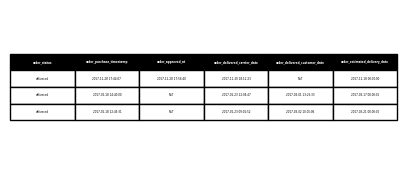

In [154]:
# Création du tableau graphique
sample = data_orders_dt_missing[0:3]

create_table_plt(sample)

# Sauvegarde en image
plt.savefig("Images_explo/tableau_dt_missing", bbox_inches='tight', dpi=600)

In [155]:
# Regardons le nombre d'observations concernées
dataframe_orders_missing[dataframe_orders_missing["order_status"] == "delivered"].shape # 23 observations concernées

(23, 8)

In [156]:
(dataframe_orders_missing[dataframe_orders_missing["order_status"] == "delivered"].shape[0] / dict_olist["olist_orders_dataset"].shape[0]) * 100

0.02312929274645267

In [157]:
# Comparaison des deux dataframes sur le statut des commandes
print("---- Pour le dataframe avec seulement ceux qui ont une date manquante ----")
print(dataframe_orders_missing["order_status"].value_counts())
print("\n")

print("---- Pour le dataframe dans sa totalitée ----")
print(dict_olist["olist_orders_dataset"]["order_status"].value_counts())


---- Pour le dataframe avec seulement ceux qui ont une date manquante ----
order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
Name: count, dtype: int64


---- Pour le dataframe dans sa totalitée ----
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


#### Commentaires

On peut observer que dans la plupart des commandes où nous avons des dates manquantes, les commandes ne sont pas encore arrivées précisées par la colonne "order_status". Seulement 23 observations peuvent être considérées comme atypiques car ils ont le statut délivrées alors que les dates sont manquantes (order_approved_at, order_delivered_carrier_date, order_delivered_customer_date). 

## Remplacer les données manquantes par None + transformation en une liste de dictionnaires

In [158]:
# Remplacement des données manquantes par None
for key in dict_olist:
  dict_olist[key] = dict_olist[key].replace({pd.NaT : None, 
                                             np.nan : None,
                                             pd.NA : None})


In [159]:
# Vérification du succès de l'opération
for key in list(dict_olist.keys())[3:]:
    print("---- Pour le fichier "+key+" ---- ")
    print(dict_olist[key].head(1))
    print("----------------------------------\n")

---- Pour le fichier olist_order_payments_dataset ---- 
                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
----------------------------------

---- Pour le fichier olist_order_reviews_dataset ---- 
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   

   review_score review_comment_title review_comment_message  \
0             4                 None                   None   

  review_creation_date review_answer_timestamp  
0           2018-01-18     2018-01-18 21:46:59  
----------------------------------

---- Pour le fichier olist_products_dataset ---- 
                         product_id product_category_name product_name_lenght  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria                  40   

  pro

In [160]:
dict_olist["olist_orders_dataset"].head(20)

order_id                       customer_id  \
0   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1   53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2   47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3   949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4   ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
5   a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
6   136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
7   6514b8ad8028c9f2cc2374ded245783f  9bdf08b4b3b52b5526ff42d37d47f222   
8   76c6e866289321a7c93b82b54852dc33  f54a9f0e6b351c431402b8461ea51999   
9   e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   
10  e6ce16cb79ec1d90b1da9085a6118aeb  494dded5b201313c64ed7f100595b95c   
11  34513ce0c4fab462a55830c0989c7edb  7711cf624183d843aafe81855097bc37   
12  82566a660a982b15fb86e904c8d32918  d3e3b74c766bc6214e0c830b17ee2341   
13  5ff96c15d0b717ac6ad1f3d77225a350  19402a48fe860416adf93348aba37740   
14  432aaf21d85167c2c86ec9448c4e42cc  3df704f53d3f1d4818840b34ec672a9f   
15  dcb36b511fcac050b97cd5c05de84dc3  3b6828a50ffe546942b7a473d70ac0fc   
16  403b97836b0c04a622354cf531062e5f  738b086814c6fcc74b8cc583f8516ee3   
17  116f0b09343b49556bbad5f35bee0cdf  3187789bec990987628d7a9beb4dd6ac   
18  85ce859fd6dc634de8d2f1e290444043  059f7fc5719c7da6cbafe370971a8d70   
19  83018ec114eee8641c97e08f7b4e926f  7f8c8b9c2ae27bf3300f670c3d478be8   

   order_status order_purchase_timestamp    order_approved_at  \
0     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1     delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2     delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3     delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4     delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
5     delivered      2017-07-09 21:57:05  2017-07-09 22:10:13   
6      invoiced      2017-04-11 12:22:08  2017-04-13 13:25:17   
7     delivered      2017-05-16 13:10:30  2017-05-16 13:22:11   
8     delivered      2017-01-23 18:29:09  2017-01-25 02:50:47   
9     delivered      2017-07-29 11:55:02  2017-07-29 12:05:32   
10    delivered      2017-05-16 19:41:10  2017-05-16 19:50:18   
11    delivered      2017-07-13 19:58:11  2017-07-13 20:10:08   
12    delivered      2018-06-07 10:06:19  2018-06-09 03:13:12   
13    delivered      2018-07-25 17:44:10  2018-07-25 17:55:14   
14    delivered      2018-03-01 14:14:28  2018-03-01 15:10:47   
15    delivered      2018-06-07 19:03:12  2018-06-12 23:31:02   
16    delivered      2018-01-02 19:00:43  2018-01-02 19:09:04   
17    delivered      2017-12-26 23:41:31  2017-12-26 23:50:22   
18    delivered      2017-11-21 00:03:41  2017-11-21 00:14:22   
19    delivered      2017-10-26 15:54:26  2017-10-26 16:08:14   

   order_delivered_carrier_date order_delivered_customer_date  \
0           2017-10-04 19:55:00           2017-10-10 21:25:13   
1           2018-07-26 14:31:00           2018-08-07 15:27:45   
2           2018-08-08 13:50:00           2018-08-17 18:06:29   
3           2017-11-22 13:39:59           2017-12-02 00:28:42   
4           2018-02-14 19:46:34           2018-02-16 18:17:02   
5           2017-07-11 14:58:04           2017-07-26 10:57:55   
6                          None                          None   
7           2017-05-22 10:07:46           2017-05-26 12:55:51   
8           2017-01-26 14:16:31           2017-02-02 14:08:10   
9           2017-08-10 19:45:24           2017-08-16 17:14:30   
10          2017-05-18 11:40:40           2017-05-29 11:18:31   
11          2017-07-14 18:43:29           2017-07-19 14:04:48   
12          2018-06-11 13:29:00           2018-06-19 12:05:52   
13          2018-07-26 13:16:00           2018-07-30 15:52:25   
14          2018-03-02 21:09:20           2018-03-12 23:36:26   
15          2018-06-11 14:54:00           2018-06-21 15:34:32   
16

In [161]:
# Transformation en une liste de dictionnaires (records)
dict_records = {}

for key in dict_olist:
    dict_records[key] = dict_olist[key].to_dict("records") # records pour avoir le bon format des résultats

In [162]:
# Vérification du succès de l'opération
dict_records["olist_customers_dataset"]

[{'customer_id': '06b8999e2fba1a1fbc88172c00ba8bc7',
  'customer_unique_id': '861eff4711a542e4b93843c6dd7febb0',
  'customer_zip_code_prefix': 14409,
  'customer_city': 'franca',
  'customer_state': 'SP'},
 {'customer_id': '18955e83d337fd6b2def6b18a428ac77',
  'customer_unique_id': '290c77bc529b7ac935b93aa66c333dc3',
  'customer_zip_code_prefix': 9790,
  'customer_city': 'sao bernardo do campo',
  'customer_state': 'SP'},
 {'customer_id': '4e7b3e00288586ebd08712fdd0374a03',
  'customer_unique_id': '060e732b5b29e8181a18229c7b0b2b5e',
  'customer_zip_code_prefix': 1151,
  'customer_city': 'sao paulo',
  'customer_state': 'SP'},
 {'customer_id': 'b2b6027bc5c5109e529d4dc6358b12c3',
  'customer_unique_id': '259dac757896d24d7702b9acbbff3f3c',
  'customer_zip_code_prefix': 8775,
  'customer_city': 'mogi das cruzes',
  'customer_state': 'SP'},
 {'customer_id': '4f2d8ab171c80ec8364f7c12e35b23ad',
  'customer_unique_id': '345ecd01c38d18a9036ed96c73b8d066',
  'customer_zip_code_prefix': 13056,
  

# 2ème partie : l'intégration de données dans MongoDB

Après avoir donc finie d'observer la structure et préparer nos dataframes, nous allons intégrer ces données dans MongoDB via pymongo.

## Connexion + création des différentes collections

In [163]:
# Connexion à mongodb
client = MongoClient("mongodb://localhost:27017") # Connexion

In [164]:
# Vérification du succès de l'opération
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [165]:
db=client["olist"] # Sélection du database
db_agg = client["aggregation_resultat"] # Contient les résultats de nos différentes requêtes

In [166]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'olist')

In [167]:
db_agg

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'aggregation_resultat')

In [168]:
print(client.list_database_names()) # Pour le moment, il n'existe pas car il faut lui créer une collection et insérer le contenu

['admin', 'aggregation_resultat', 'config', 'local', 'olist']


In [169]:
# Création/Sélection des différentes collections qui va contenir nos sept dataframes
dict_inst_mongdb = {}
for key in dict_olist:
    coll = db[key] # Sélection de la collection
    dict_inst_mongdb[key] = coll # garder l'instance dans un dictionnaire

In [170]:
dict_inst_mongdb["olist_customers_dataset"] # On peut observer que tout se passe bien pour le moment

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'olist'), 'olist_customers_dataset')

## Insertion des données

Maintenant que nous avons finie de créer notre base et nos sept collections, nous allons pouvoir commencer l'insertion. Pour ce faire, nous allons reprendre le dictionnaire des instances (dict_inst) contenant pour chaque collection associée la liste de dictionnaire associées.

In [171]:
for key in dict_inst_mongdb:
    # Vérifie s'il n'a pas été déjà inséré
    if dict_inst_mongdb[key].count_documents({}) > 0:
        print("--- Présence de données dans la collection {}, pas d'insertions à faire ----".format(key))
    else:
        print("---- Insertion dans la collection "+key + " ----")
        dict_inst_mongdb[key].insert_many(dict_records[key])
        print("---- Insertion réussie ----\n")

--- Présence de données dans la collection olist_customers_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_orders_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_order_items_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_order_payments_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_order_reviews_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_products_dataset, pas d'insertions à faire ----
--- Présence de données dans la collection olist_sellers_dataset, pas d'insertions à faire ----


Nous devrions pouvoir maintenant voir notre nouvelle base de données et ses collections créées sur mongodb.

# **3ème partie : analyse exploratoire des données via les requêtes MongoDB**

Dans cette dernière partie, nous allons procéder à une petite analyse exploratoire de nos données pour observer les tendances par catégories de produit, période dans l’année, satisfaction etc. Cela se traduira par des visuels graphiques (plotnine) dont les résultats seront basées sur des requêtes de type MongoDB.

In [172]:
# Création d'une fct utilitaire pour récupérer/montrer les résultats du cursor
def print_cursor(cursor, aff=True):
    """
    Fonction : permet de montrer les résultats d'un curseur après exécution d'une requête de type MongoDB (pymongo)

    Argument :
    - cursor : le curseur en question à parcourir

    Retour :
    retourne une liste des résultats du cursor et les affiche aussi
    """

    liste_cursor = []
    for res in cursor:
        if aff :
            print(res)
        liste_cursor.append(res)
    return liste_cursor

## Création des index (augmenter les performances des requêtes)

In [173]:
# Création de tous les index pour la performance des requêtes mongodb 

# Pour la collection products_dataset
dict_inst_mongdb["olist_products_dataset"].create_index([("product_id", 1)], unique=True)
dict_inst_mongdb["olist_products_dataset"].create_index({"product_category_name" : 1})

# Pour la collection order_items_dataset
dict_inst_mongdb["olist_order_items_dataset"].create_index([("product_id", 1)])
dict_inst_mongdb["olist_order_items_dataset"].create_index([("seller_id", 1)])
dict_inst_mongdb["olist_order_items_dataset"].create_index([("order_id", 1)])

# Pour la collection order_dataset
dict_inst_mongdb["olist_orders_dataset"].create_index([("order_id", 1)], unique=True)
dict_inst_mongdb["olist_orders_dataset"].create_index([("customer_id", 1)])

# Pour la collection customers_dataset
dict_inst_mongdb["olist_customers_dataset"].create_index([("customer_id", 1)], unique=True)
dict_inst_mongdb["olist_customers_dataset"].create_index([("customer_state", 1)])

# Pour la collection order_reviews_dataset
dict_inst_mongdb["olist_order_reviews_dataset"].create_index([("review_id", 1)])
dict_inst_mongdb["olist_order_reviews_dataset"].create_index([("order_id", 1)])

# Pour la collection sellers_dataset
dict_inst_mongdb["olist_sellers_dataset"].create_index([("seller_id", 1)], unique=True)
dict_inst_mongdb["olist_sellers_dataset"].create_index([("seller_state", 1)])

'seller_state_1'

## **Le prix moyen des articles par catégorie de produit chez Olist**

### *Requête MongoDB*

In [174]:
# Création du Pipeline sur la jointure et la moyenne par mongodb

# Jointure pour avoir les catégories de produits
stage_lookup_products = {
    "$lookup" : {
        "from" : "olist_products_dataset",
        "localField" : "product_id", # id dans la table initiale
        "foreignField" : "product_id", # id de la table étrangère
        "as" : "related_product" # nom de colonne ajoutée
    }
}

# Sélection des colonnes
elts_products = {
    "$project" :
    {
        "_id" : 0, 
        "price" : 1,
        'categorie' : {"$first" : "$related_product.product_category_name"} # Attribut étrangère
    }
}

# Mettre dans l'ordre les différents catégories de produit
sort_products = {
    "$sort" : { "average_price" : -1 } 
}

# Faire la moyenne des prix par catégorie de produit (group_by)
stage_group_products = {
    "$group" : {
        "_id" : "$categorie",
        "average_price": { "$avg": "$price" }
    }

}

# Sauvegarder les résultats dans une nouvelle base pour les récupérer ensuite
out_products = {"$out" : {"db" : "aggregation_resultat", "coll" : "avg_price_prod"}}

# Création du pipeline
pipeline = [
stage_lookup_products,
elts_products,
stage_group_products,
sort_products,
out_products
]

In [175]:
# Application du pipeline
results = dict_inst_mongdb["olist_order_items_dataset"].aggregate(pipeline)

In [176]:
# Récupération des résultats sous forme de liste
results = list(db_agg["avg_price_prod"].find())

In [177]:
# Vérification du succès de l'opération
results

[{'_id': 'pcs', 'average_price': 1098.3405418719212},
 {'_id': 'portateis_casa_forno_e_cafe', 'average_price': 624.2856578947368},
 {'_id': 'eletrodomesticos_2', 'average_price': 476.1249579831933},
 {'_id': 'agro_industria_e_comercio', 'average_price': 342.12485849056606},
 {'_id': 'instrumentos_musicais', 'average_price': 281.616},
 {'_id': 'eletroportateis', 'average_price': 280.7784683357879},
 {'_id': 'portateis_cozinha_e_preparadores_de_alimentos',
  'average_price': 264.5686666666667},
 {'_id': 'telefonia_fixa', 'average_price': 225.6931818181818},
 {'_id': 'construcao_ferramentas_seguranca',
  'average_price': 208.9923711340206},
 {'_id': 'relogios_presentes', 'average_price': 201.13598397596394},
 {'_id': 'climatizacao', 'average_price': 185.26922558922558},
 {'_id': 'moveis_quarto', 'average_price': 183.75027522935778},
 {'_id': 'pc_gamer', 'average_price': 171.77222222222224},
 {'_id': 'cool_stuff', 'average_price': 167.357968914647},
 {'_id': 'moveis_cozinha_area_de_servico

### *Mise en forme des résultats*

In [178]:
# Transformation en dataframe
products_avg_price = pd.DataFrame(list(results))

In [179]:
# Vérification du succès de l'opération
products_avg_price

_id  average_price
0                           pcs    1098.340542
1   portateis_casa_forno_e_cafe     624.285658
2            eletrodomesticos_2     476.124958
3     agro_industria_e_comercio     342.124858
4         instrumentos_musicais     281.616000
..                          ...            ...
69            alimentos_bebidas      54.602446
70            cds_dvds_musicais      52.142857
71              fraldas_higiene      40.194615
72                       flores      33.637576
73              casa_conforto_2      25.342333

[74 rows x 2 columns]

#### Les 10 catégories de produits les plus chers

In [180]:
# Regardons le top 10 des catégories de produits les plus chères
top_10_plus_cher = products_avg_price.iloc[0:11]

In [181]:
# Vérification du succès de l'opération
top_10_plus_cher

_id  average_price
0                                             pcs    1098.340542
1                     portateis_casa_forno_e_cafe     624.285658
2                              eletrodomesticos_2     476.124958
3                       agro_industria_e_comercio     342.124858
4                           instrumentos_musicais     281.616000
5                                 eletroportateis     280.778468
6   portateis_cozinha_e_preparadores_de_alimentos     264.568667
7                                  telefonia_fixa     225.693182
8                construcao_ferramentas_seguranca     208.992371
9                              relogios_presentes     201.135984
10                                   climatizacao     185.269226

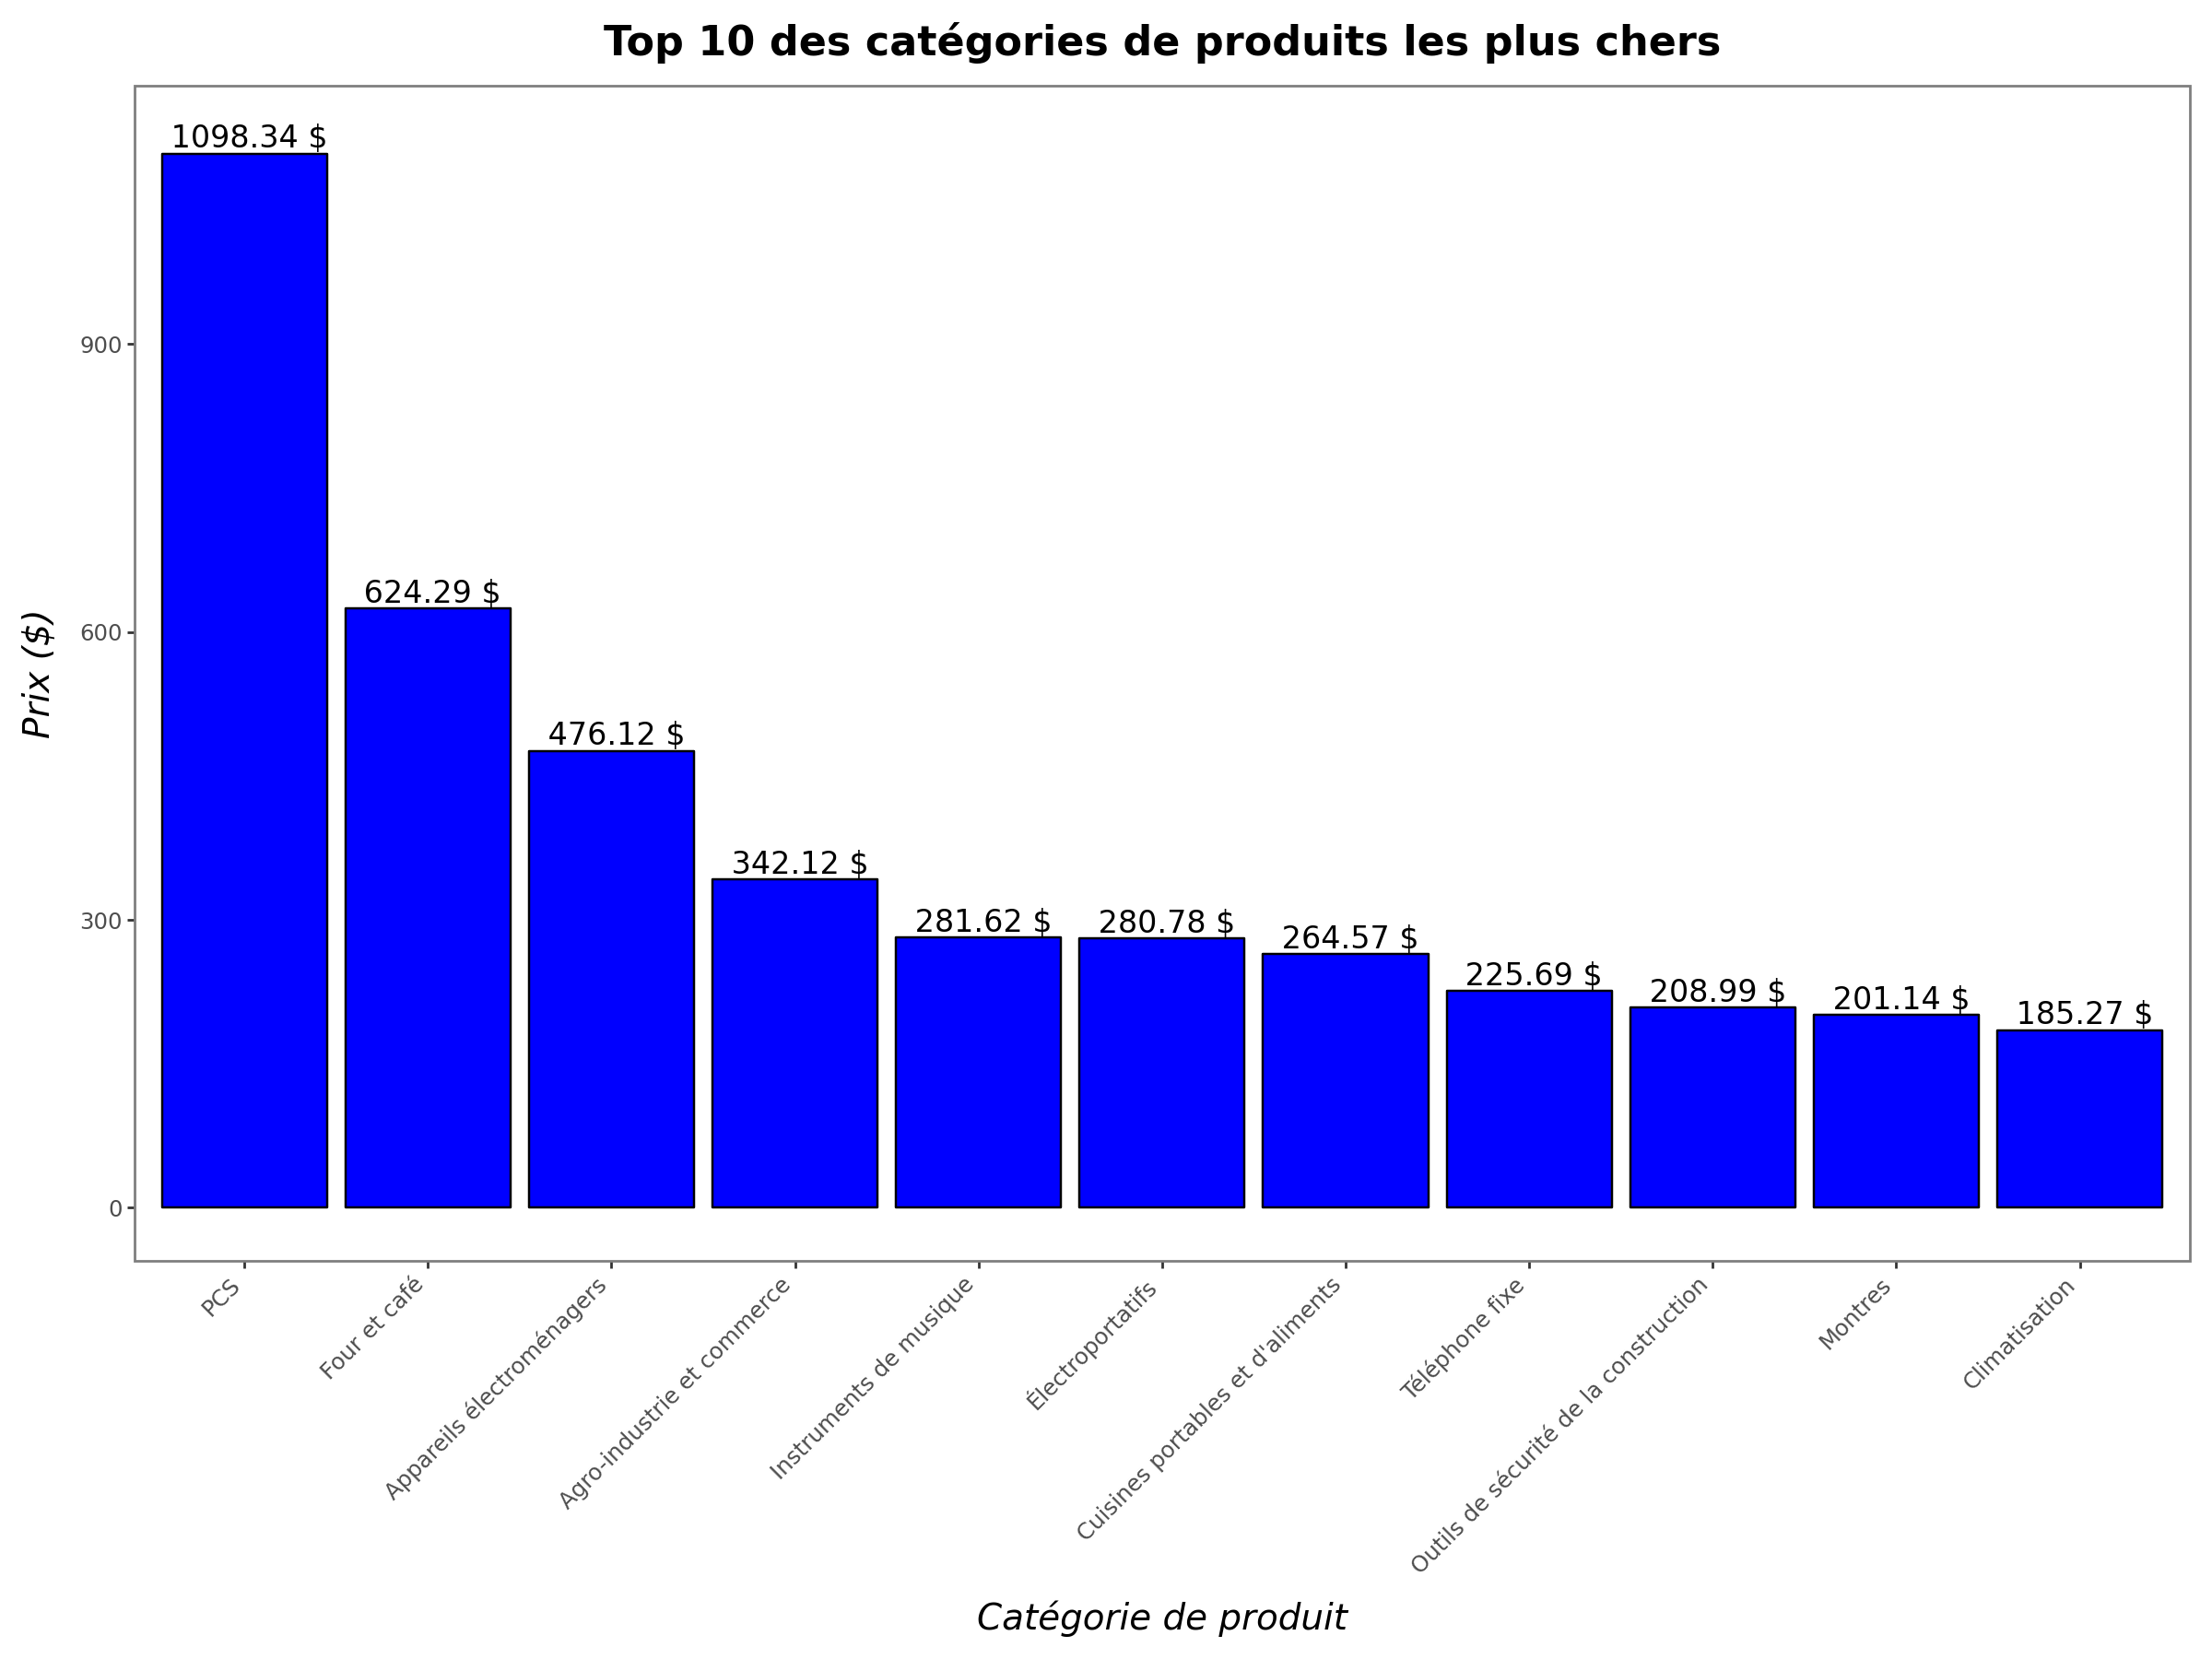

In [182]:
# Visuel graphique (plotnine)
theme_list = list(top_10_plus_cher["_id"])

# Traduction française :
theme_list_labels_fr = ["PCS",
"Four et café",
"Appareils électroménagers",
"Agro-industrie et commerce",
"Instruments de musique",
"Électroportatifs",
"Cuisines portables et d'aliments",
"Téléphone fixe",
"Outils de sécurité de la construction",
"Montres",
"Climatisation"]

(
plotn.ggplot(top_10_plus_cher, plotn.aes(x="_id", y="average_price")) # Jeu de données
    + plotn.geom_bar(stat = "identity",
                   color="black",
                   fill="blue") # Ajout du type de graphique avec couleur des bordures + barres
    + plotn.labs(title="Top 10 des catégories de produits les plus chers",
               x = "Catégorie de produit",
               y = "Prix ($)") # Ajout des titres
    + plotn.geom_text(
        plotn.aes(label = "average_price"),
        size = 12,
        nudge_y=15,
        format_string="{: .2f} $") # Ajout des valeurs avec le symbole en dollar
    + plotn.scale_x_discrete(limits=theme_list, labels=theme_list_labels_fr) # Ordre décroissante
    + plotn.theme_bw() # Thème utilisé
    + plotn.theme(figure_size=(12, 9), # Taille de la figure
                axis_text_x = plotn.element_text(angle = 45, hjust = 1), # Mise en forme du texte pour les labels d'axe X
                panel_grid= plotn.element_blank(), # Enlever les carreaux gris
                plot_title=plotn.element_text(size=16, face='bold'), # Mise en forme du titre principale
                axis_title=plotn.element_text(size=14, face='italic')) # Mise en forme des titres d'axes
)

#### Commentaire :
On peut observer que le top quatre des catégories de produits les plus cher sont PCS (1 098 \$), Four et café (624 \$), Appareils électroménager (476 \$) et Agro-industrie et commerce (342 \$). Pour les autres catégories de produits dans le top 10, le prix est entre 185 \$ et 282 \$ ce qui est quand même un écart important par rapport au top 4. La catégorie de produit la plus cher est très éloignée du deuxième avec presque 500 \$ de différence entre les deux.

#### Les 10 catégories de produits les moins chers

In [183]:
# Regardons le top 10 des produits les moins cher
top_10_moins_cher = products_avg_price.iloc[-1:-11:-1]

In [184]:
# Vérification du succès de l'opération
top_10_moins_cher

_id  average_price
73         casa_conforto_2      25.342333
72                  flores      33.637576
71         fraldas_higiene      40.194615
70       cds_dvds_musicais      52.142857
69       alimentos_bebidas      54.602446
68        artigos_de_natal      57.521699
67               alimentos      57.634137
66             eletronicos      57.913531
65  fashion_roupa_feminina      58.409167
64                 bebidas      59.178628

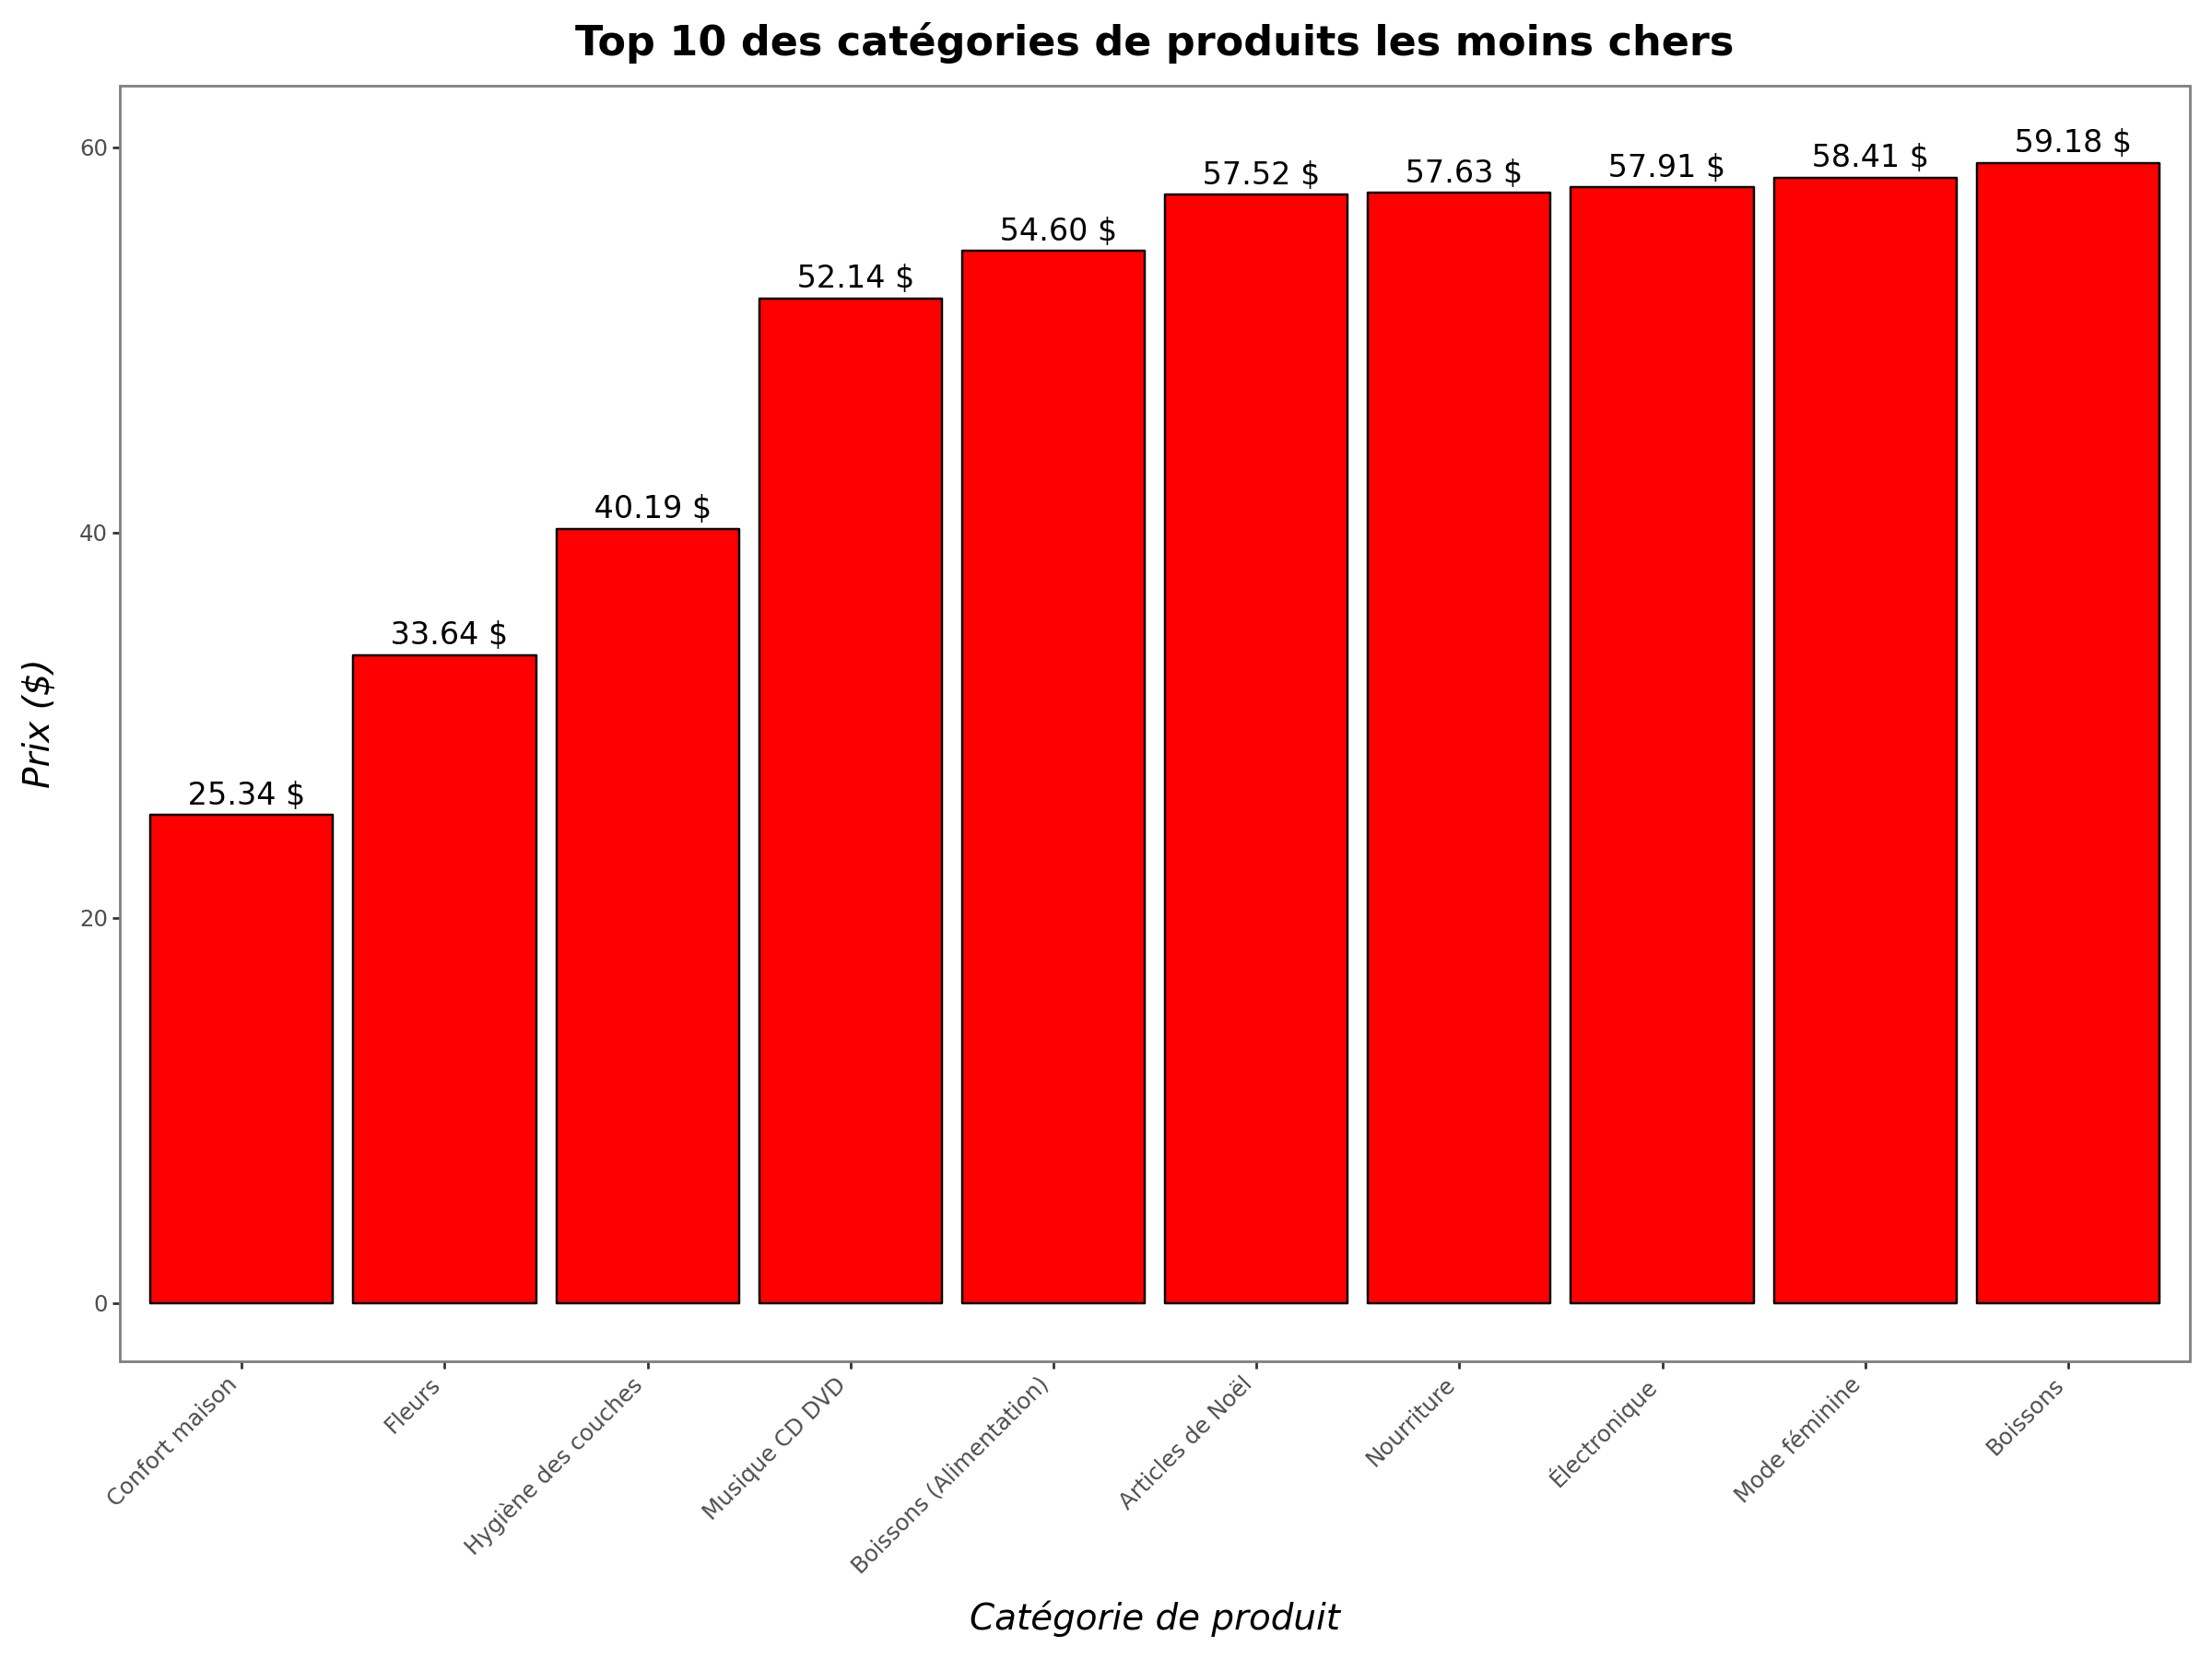

In [185]:
# Visuel graphique (plotnine)
theme_list = list(top_10_moins_cher["_id"])

# Traduction française :
theme_list_labels_fr = ["Confort maison",
"Fleurs",
"Hygiène des couches",
"Musique CD DVD",
"Boissons (Alimentation)",
"Articles de Noël",
"Nourriture",
"Électronique",
"Mode féminine",
"Boissons"]

(
plotn.ggplot(top_10_moins_cher, plotn.aes(x="_id", y="average_price")) # Jeu de données
    + plotn.geom_bar(stat = "identity",
                   color="black",
                   fill="red") # Ajout du type de graphique avec couleur des bordures + barres
    + plotn.labs(title="Top 10 des catégories de produits les moins chers",
               x = "Catégorie de produit",
               y = "Prix ($)") # Ajout des titres
    + plotn.geom_text(
        plotn.aes(label = "average_price"),
        size = 12,
        nudge_y=1,
        format_string="{: .2f} $") # Ajout des étiquettes de valeurs avec le symbole en dollar
    + plotn.scale_x_discrete(limits=theme_list, labels=theme_list_labels_fr) # Ordre croissante
    + plotn.theme_bw() # Thème utilisé
    + plotn.theme(figure_size=(12, 9), # Taille de la figure
                axis_text_x = plotn.element_text(angle = 45, hjust = 1), # Rotation de 45 degrés de nos labels sur l'axe X
                panel_grid= plotn.element_blank(), # Enlever les carreaux grix
                plot_title=plotn.element_text(size=16, face='bold'), # Mise en forme du texte pour le titre principale
                axis_title=plotn.element_text(size=14, face='italic')) # Mise en forme des titres d'axes principales
)

#### Commentaire :

On peut remarquer que la catégorie de produit la moins chère est "confort maison" avec seulement comme prix 25.34 \$ environ. Elle est suivie des fleurs avec 33.64 \$ et de l'hygiène des couches pour 40.19 \$. Toutes les autres catégories de produits sont dans les 50 \$ environ.

## **Les vendeurs les mieux notés**

### *Requête MongoDB*

In [186]:
# Création du Pipeline sur les différentes jointures à faire et calculer la moyenne des notes par vendeur

# Jointure pour avoir les items
stage_lookup_seller_items = {
    "$lookup" : {
        "from" : "olist_order_items_dataset",
        "localField" : "seller_id", 
        "foreignField" : "seller_id", 
        "as" : "related_items" 
    }
}

# Jointure pour avoir les orders
stage_lookup_order = {
    "$lookup" : {
        "from" : "olist_orders_dataset",
        "localField" : "related_items.order_id", 
        "foreignField" : "order_id", 
        "as" : "related_orders" 
    }
}

# Jointure pour avoir les différents scores par rapport à la commande
stage_lookup_review = {
    "$lookup" : {
        "from" : "olist_order_reviews_dataset",
        "localField" : "related_orders.order_id", 
        "foreignField" : "order_id", 
        "as" : "related_reviews" 
    }
}

# Calcul de la longueur de la liste related_orders pour savoir le nombre de commande
# Calcul de la moyenne des notes dans la liste related_reviews
length_orders_avg_score = {
        '$addFields': {
          'nb_orders': {
            '$size': '$related_orders'
          },
          "avg_review_score" : {
              "$avg" : "$related_reviews.review_score"
          }
        }
      }

# Mettre dans l'ordre décroissante selon le review_score et le nombre de commandes liées
sort_scoring ={
    "$sort" : {
        "avg_review_score" : -1,
        "nb_orders" : -1
    }
} 

# Sélection des colonnes
elts_sellers = {
    "$project" :
    {
        "_id" : 0, 
        "seller_id" : 1,
        #"related_reviews.review_score" : 1,
        #"related_orders.order_id" : 1,
        "nb_orders" : 1,
        "avg_review_score" : 1
    }
}

# Limiter au 10 premiers vendeurs
limit_10_vend = {
    "$limit": 10
}

# Sauvegarder les résultats dans une nouvelle collection
out_sellers = {"$out" : {"db" : "aggregation_resultat", "coll" : "top_10_vendeurs"}}

# Création du pipeline
pipeline = [
stage_lookup_seller_items,
stage_lookup_order,
stage_lookup_review,
length_orders_avg_score,
sort_scoring,
elts_sellers,
limit_10_vend,
out_sellers
]

In [187]:
# Application du pipeline
results = dict_inst_mongdb["olist_sellers_dataset"].aggregate(pipeline)

In [188]:
liste_results = list(db_agg["top_10_vendeurs"].find())

In [189]:
print(liste_results)

[{'_id': ObjectId('677c4a8d1f2881a1b5366c29'), 'seller_id': '48efc9d94a9834137efd9ea76b065a38', 'nb_orders': 33, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2a'), 'seller_id': '2addf05f476d0637864454e93ba673d5', 'nb_orders': 12, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2b'), 'seller_id': 'b2eecf5ea250510da76590ca79d60e5d', 'nb_orders': 9, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2c'), 'seller_id': '293dee954235e4e4e43f129313625ebe', 'nb_orders': 8, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2d'), 'seller_id': '404e1ba01358af4cd63f679b2c4d1fa1', 'nb_orders': 8, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2e'), 'seller_id': 'ec933281fb017b5020d06df29c3f77e8', 'nb_orders': 8, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b5366c2f'), 'seller_id': '297d5eccd19fa9a83b2630071ff105e4', 'nb_orders': 8, 'avg_review_score': 5.0}, {'_id': ObjectId('677c4a8d1f2881a1b536

### *Mise en forme des résultats*

In [190]:
top_10_vendeurs = pd.DataFrame(liste_results)

In [191]:
top_10_vendeurs.drop("_id", axis=1, inplace=True)

In [192]:
top_10_vendeurs

seller_id  nb_orders  avg_review_score
0  48efc9d94a9834137efd9ea76b065a38         33               5.0
1  2addf05f476d0637864454e93ba673d5         12               5.0
2  b2eecf5ea250510da76590ca79d60e5d          9               5.0
3  293dee954235e4e4e43f129313625ebe          8               5.0
4  404e1ba01358af4cd63f679b2c4d1fa1          8               5.0
5  ec933281fb017b5020d06df29c3f77e8          8               5.0
6  297d5eccd19fa9a83b2630071ff105e4          8               5.0
7  c03121937e54a93fcc1825c3098bbb6e          7               5.0
8  c8c1bea22194a4eefa2dc9a9fa89f536          7               5.0
9  c3fe93ba3085f92855c97e57f38c8c05          7               5.0

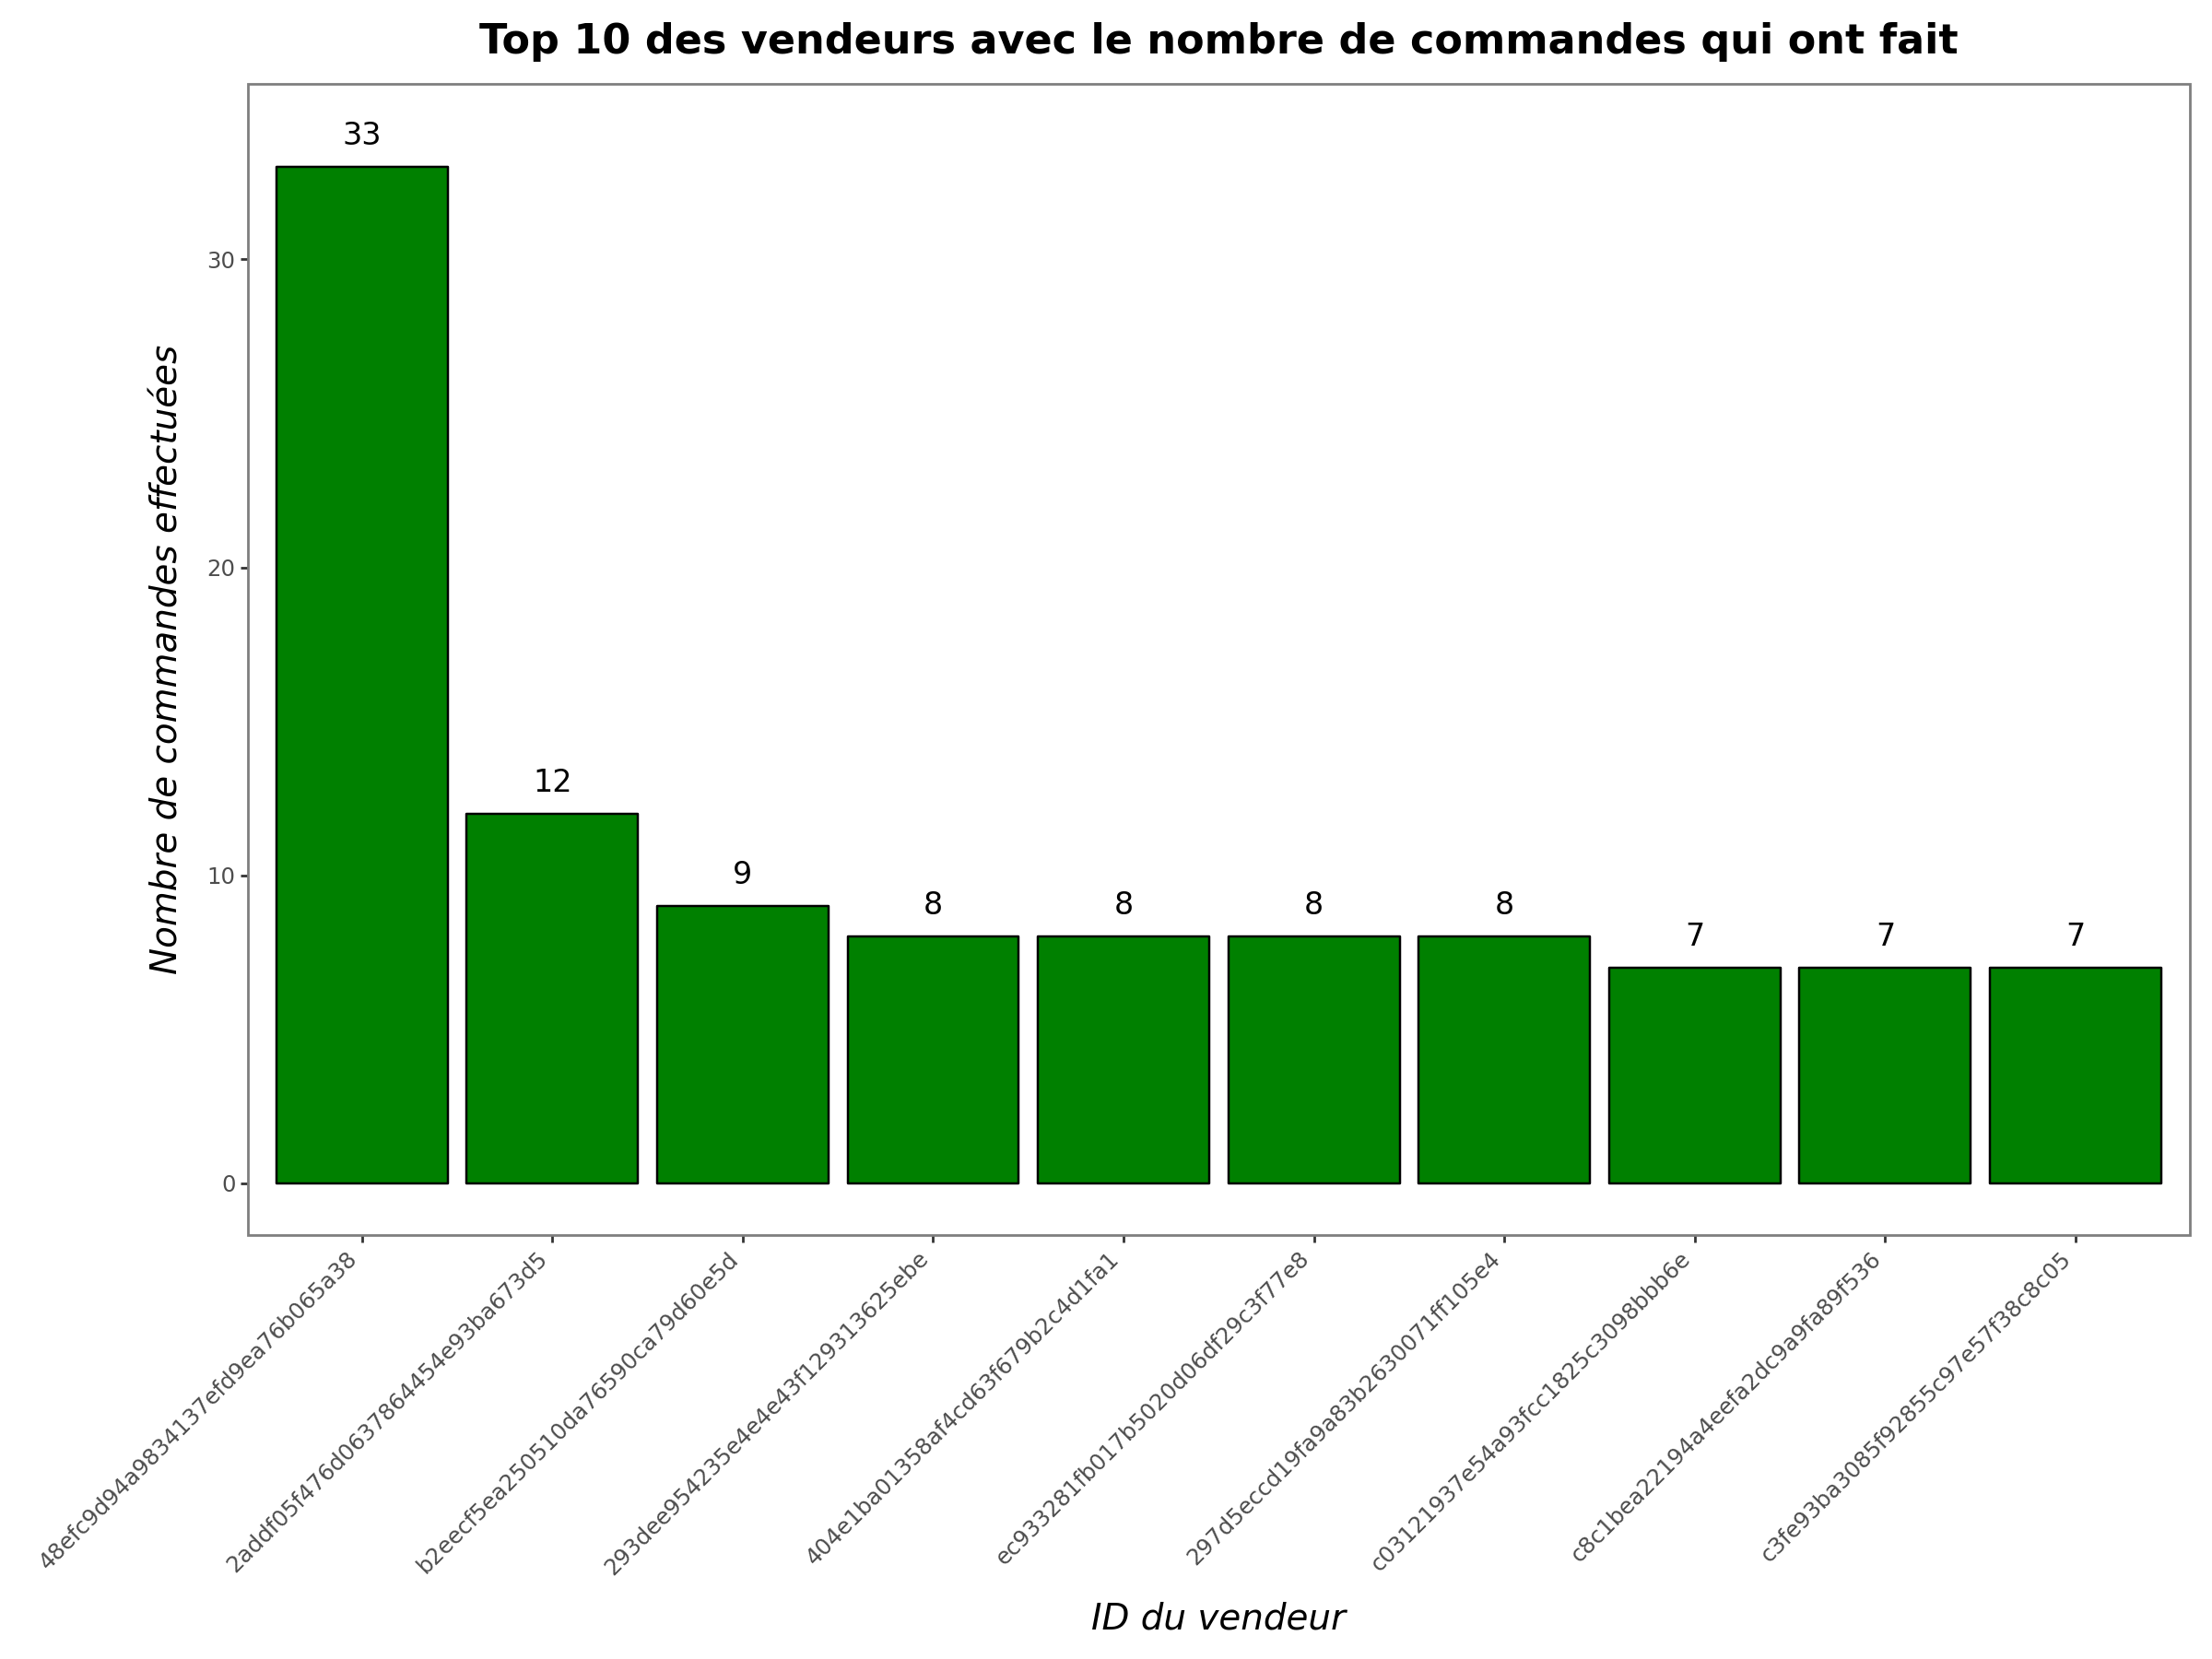

In [193]:
# Visuel graphique (plotnine)
theme_list = list(top_10_vendeurs["seller_id"])

(
plotn.ggplot(top_10_vendeurs, plotn.aes(x="seller_id", y="nb_orders")) # Jeu de données
    + plotn.geom_bar(stat = "identity",
                   color="black",
                   fill="green") # Ajout du type de graphique avec couleur des bordures + barres
    + plotn.labs(title="Top 10 des vendeurs avec le nombre de commandes qui ont fait",
               x = "ID du vendeur",
               y = "Nombre de commandes effectuées") # Ajout des titres
    + plotn.geom_text(
        plotn.aes(label = "nb_orders"),
        size = 12,
        nudge_y=1) # Ajout des étiquettes de valeurs
    + plotn.scale_x_discrete(limits=theme_list) # Ordre décroissante
    + plotn.theme_bw() # Thème utilisé
    + plotn.theme(figure_size=(12, 9), # Taille de la figure
                axis_text_x = plotn.element_text(angle = 45, hjust = 1),
                panel_grid= plotn.element_blank(),
                plot_title=plotn.element_text(size=16, face='bold'),
                axis_title=plotn.element_text(size=14, face='italic'))
)

## **Délais de livraison avec la moyenne**

### *Requête MongoDB*

In [194]:
# Créer la colonne delay basées sur deux colonnes
mod_delay = dict_inst_mongdb["olist_orders_dataset"].update_many({}, [{"$set" : {"delay_delivery" : {"$dateDiff" : {
                                                                              "startDate" : "$order_purchase_timestamp", # Date d'achat
                                                                              "endDate" : "$order_delivered_customer_date", # Date de livraison factuelle chez le client
                                                                              "unit" : "day"} # Unité de temps (day : jour)
                                                                              }}}]
                                                                              )
# dateDiff : permet de calculer la différence entre deux dates
# Savoir le nombre de lignes modifiées
print(mod_delay.modified_count, "observations modifiées.")

0 observations modifiées.


In [195]:
# Vérification du succès de l'opération

# Limiter le nombre d'observations
limite_obs = {
    "$limit": 10
}

results = dict_inst_mongdb["olist_orders_dataset"].aggregate([limite_obs])

In [196]:
# Utilisation de print_cursor
res = print_cursor(results, True)

{'_id': ObjectId('6772dd7fa314f18a2c7fd57b'), 'order_id': 'e481f51cbdc54678b7cc49136f2d6af7', 'customer_id': '9ef432eb6251297304e76186b10a928d', 'order_status': 'delivered', 'order_purchase_timestamp': datetime.datetime(2017, 10, 2, 10, 56, 33), 'order_approved_at': datetime.datetime(2017, 10, 2, 11, 7, 15), 'order_delivered_carrier_date': datetime.datetime(2017, 10, 4, 19, 55), 'order_delivered_customer_date': datetime.datetime(2017, 10, 10, 21, 25, 13), 'order_estimated_delivery_date': datetime.datetime(2017, 10, 18, 0, 0), 'delay_delivery': 8}
{'_id': ObjectId('6772dd7fa314f18a2c7fd57c'), 'order_id': '53cdb2fc8bc7dce0b6741e2150273451', 'customer_id': 'b0830fb4747a6c6d20dea0b8c802d7ef', 'order_status': 'delivered', 'order_purchase_timestamp': datetime.datetime(2018, 7, 24, 20, 41, 37), 'order_approved_at': datetime.datetime(2018, 7, 26, 3, 24, 27), 'order_delivered_carrier_date': datetime.datetime(2018, 7, 26, 14, 31), 'order_delivered_customer_date': datetime.datetime(2018, 8, 7, 15

In [197]:
# Calculons maintenant le délais moyen de livraison
avg_delay = {
    "$group" : {
        "_id" : None,
        "average_delay": { "$avg": "$delay_delivery" }
    }
}

In [198]:
# Application de la requête SQL
results = dict_inst_mongdb["olist_orders_dataset"].aggregate([avg_delay])

In [199]:
# Vérification du succès de l'opération
delay_delivery_average = results.next()

In [200]:
print("Le temps de délai moyen d'une livraison est de "+str(round(delay_delivery_average["average_delay"], 1))+" jours") # Moyenne de 12.5 jours d'attente de livraison

Le temps de délai moyen d'une livraison est de 12.5 jours


## **7 premiers États les plus prolifiques**

### *Requête MongoDB*

In [201]:
# Création du Pipeline sur les différentes jointures à faire et compter le nombre de commandes par états

# Jointure pour avoir les orders
stage_lookup_state_orders = {
    "$lookup" : {
        "from" : "olist_orders_dataset",
        "localField" : "customer_id", 
        "foreignField" : "customer_id", 
        "as" : "related_orders" 
    }
}

# Calcul de la longueur de la liste related_orders pour savoir le nombre de commande
length_orders = {
        '$addFields': {
          'nb_orders': {
            '$size': '$related_orders'
          }
      }
}

# Sélection des colonnes
elts_states = {
    "$project" :
    {
        "_id" : 0, 
        "customer_state" : 1,
        #"related_orders.order_id" : 1,
        "nb_orders" : 1
    }
}

# Grouper par États
stage_group_states = {
    "$group" : {
        "_id" : "$customer_state",
        "sum_orders": { "$sum": "$nb_orders" }
    }
}

# Classer par ordre croissant
ordre_croissant = {
    "$sort" : {
        "sum_orders" : 1
    }
}

# Classer par ordre décroissant
ordre_decroissant = {
    "$sort" : {
        "sum_orders" : -1
    }
}

# Limiter au 7 premiers états
limit_7_states = {
    "$limit": 7
}

# Sauvegarder les résultats dans une nouvelle collection
out_states = {"$out" : {"db" : "olist", "coll" : "top_etats"}}

# Création du pipeline
pipeline = [
stage_lookup_state_orders,
length_orders,
elts_states,
stage_group_states,
ordre_decroissant,
limit_7_states,
ordre_croissant,
out_states
]

In [202]:
# Application du pipeline
results = dict_inst_mongdb["olist_customers_dataset"].aggregate(pipeline)

In [203]:
results = db["top_etats"].find()

In [204]:
results = list(results)

In [205]:
results

[{'_id': 'BA', 'sum_orders': 3380},
 {'_id': 'SC', 'sum_orders': 3637},
 {'_id': 'PR', 'sum_orders': 5045},
 {'_id': 'RS', 'sum_orders': 5466},
 {'_id': 'MG', 'sum_orders': 11635},
 {'_id': 'RJ', 'sum_orders': 12852},
 {'_id': 'SP', 'sum_orders': 41746}]

### *Mise en forme des résultats*

In [206]:
etats_plus_prolifiques = pd.DataFrame(results)

In [207]:
etats_plus_prolifiques.sort_values("sum_orders", ascending=False, inplace=True) # Ordonner dans l'ordre décroissante

In [208]:
etats_plus_prolifiques["sum_orders_thousand"] = etats_plus_prolifiques["sum_orders"] / 1000

In [209]:
etats_plus_prolifiques

_id  sum_orders  sum_orders_thousand
6  SP       41746               41.746
5  RJ       12852               12.852
4  MG       11635               11.635
3  RS        5466                5.466
2  PR        5045                5.045
1  SC        3637                3.637
0  BA        3380                3.380

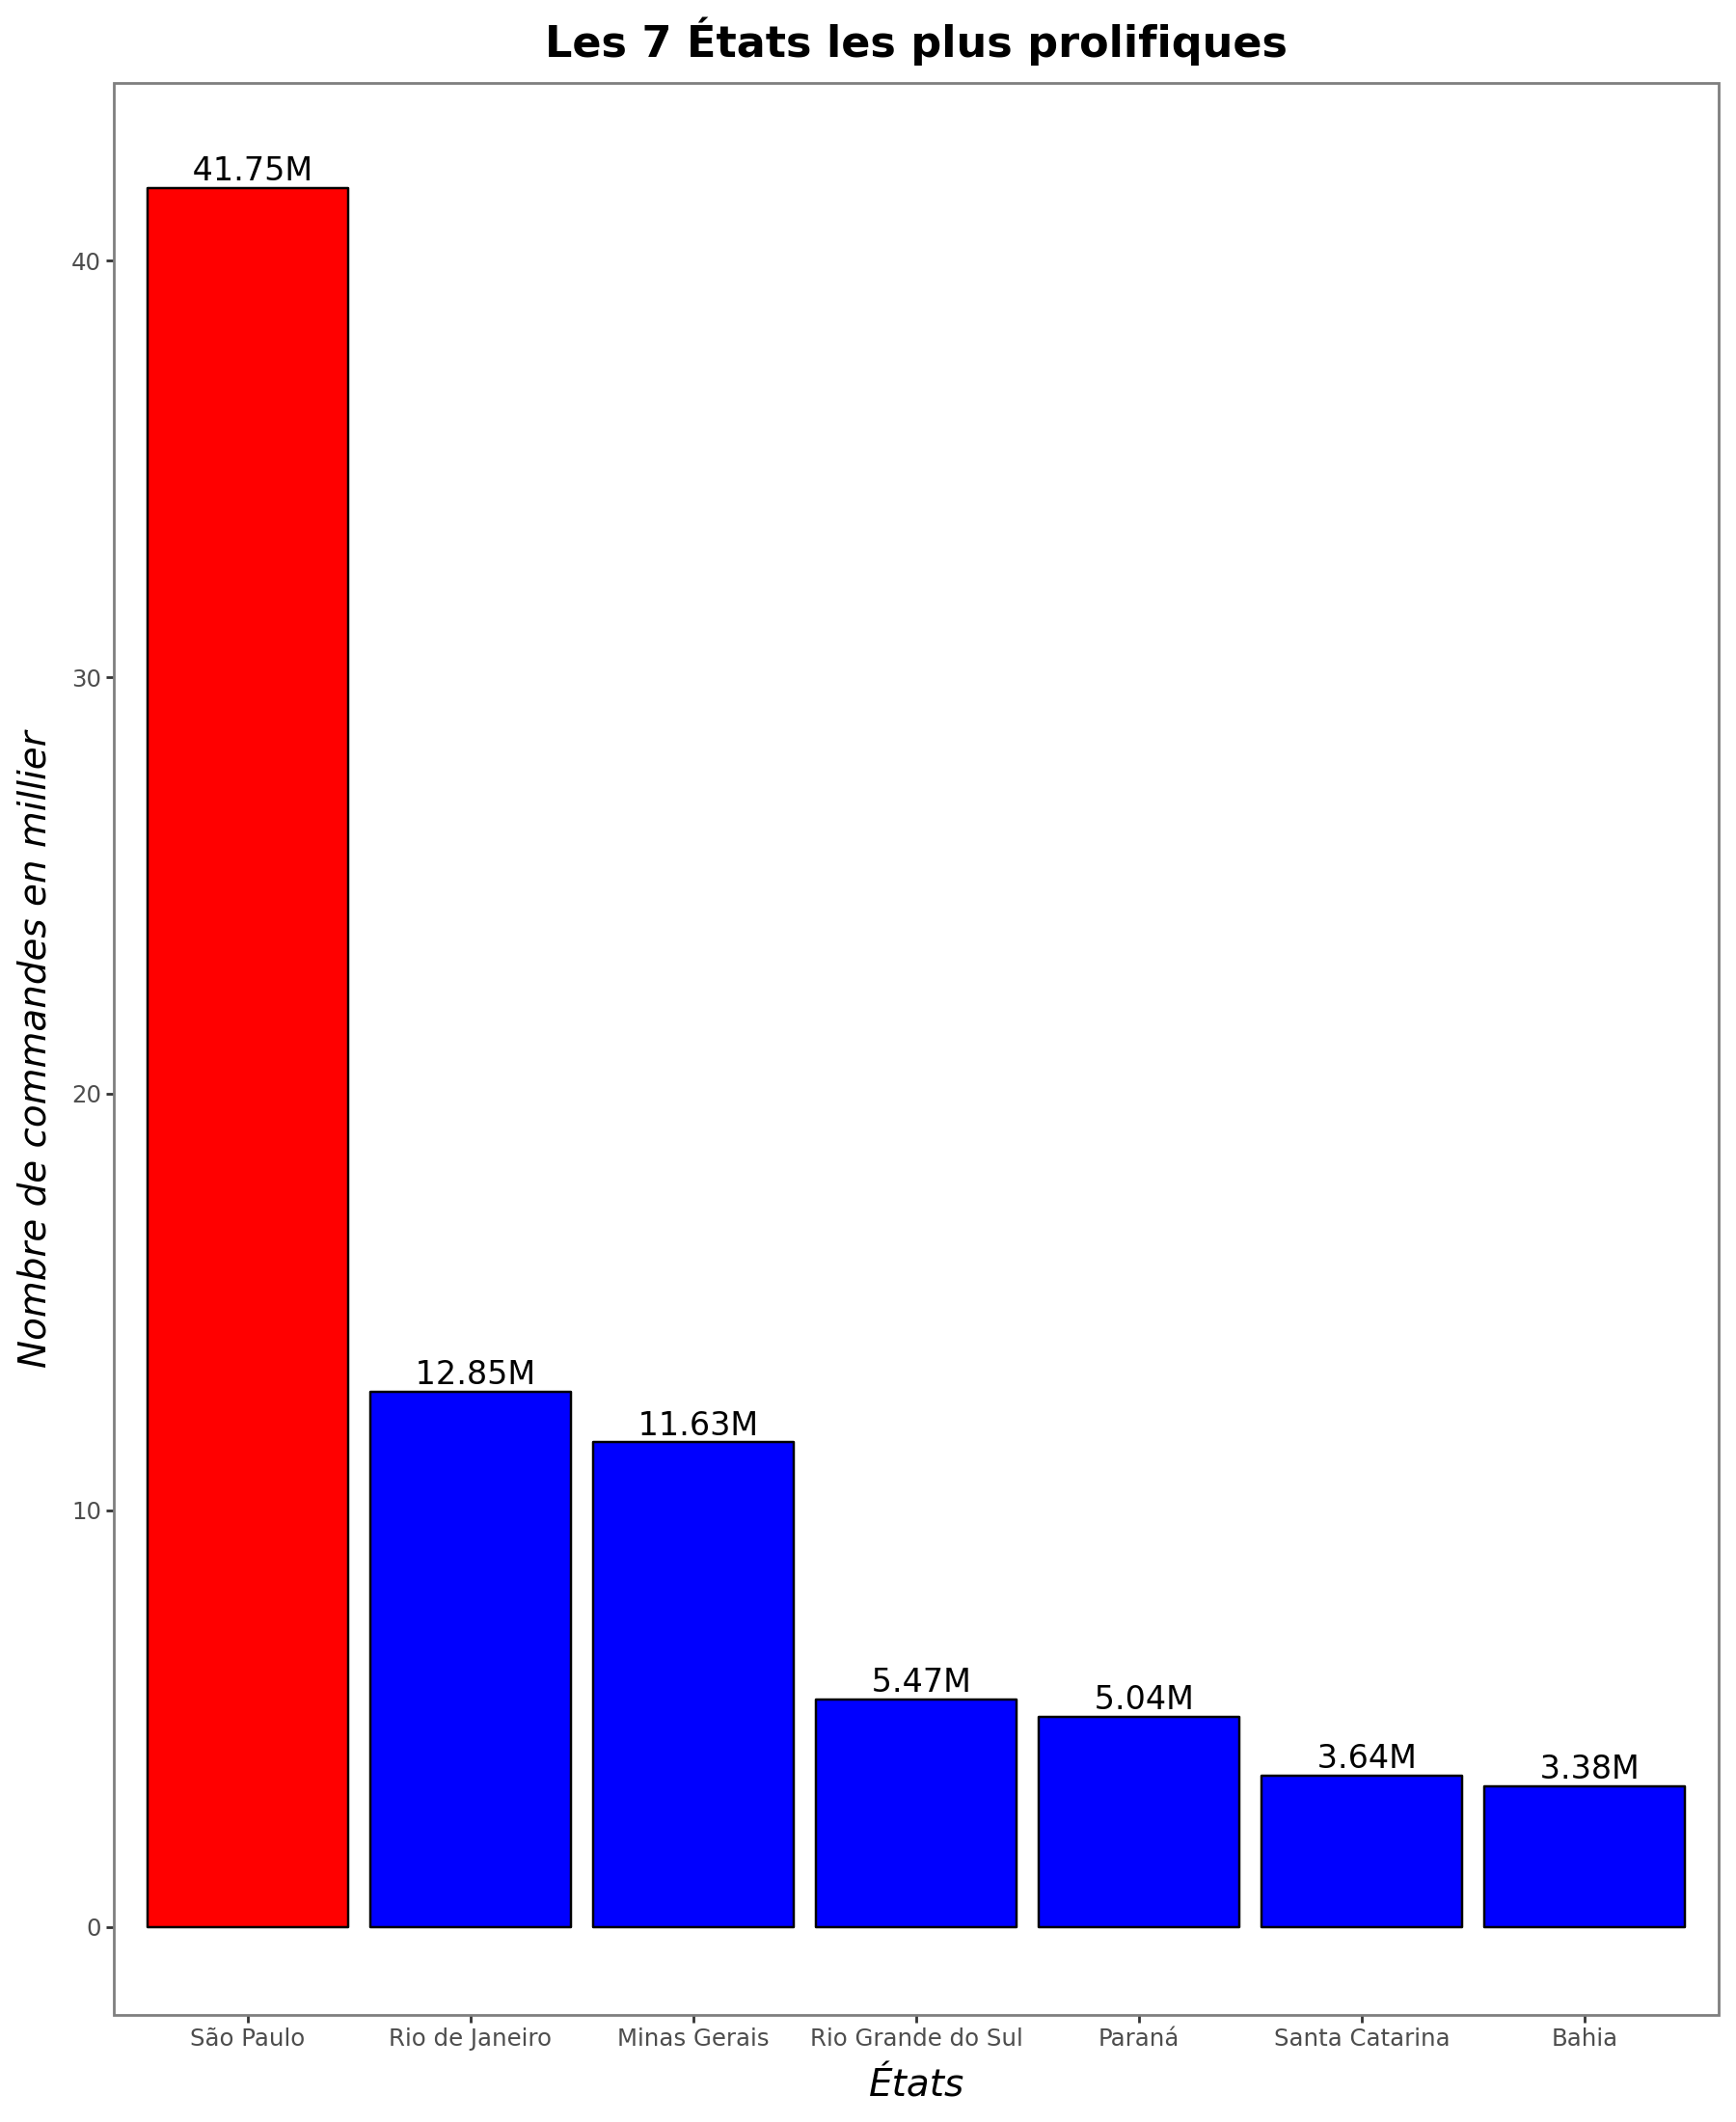

In [210]:
# Visuel graphique
# Visuel graphique (plotnine)
theme_list = list(etats_plus_prolifiques["_id"])

# Les vrais noms d'états :
theme_list_labels = ["São Paulo", "Rio de Janeiro", 
                      "Minas Gerais", "Rio Grande do Sul", "Paraná",
                      "Santa Catarina", "Bahia"]

etats_plus_prolifiques['Couleur'] = ['Première'] + ['Autres'] * (len(etats_plus_prolifiques) - 1)

(
plotn.ggplot(etats_plus_prolifiques, plotn.aes(x="_id", y="sum_orders_thousand", fill="Couleur")) # Jeu de données
    + plotn.geom_bar(stat = "identity",
                   color="black") # Ajout du type de graphique avec couleur des bordures + barres
    + plotn.labs(title="Les 7 États les plus prolifiques",
               x = "États",
               y = "Nombre de commandes en millier") # Ajout des titres
    + plotn.geom_text(
        plotn.aes(label = "sum_orders_thousand"),
        size = 12,
        nudge_y=0.4,
        format_string = "{: .2f}M"
        )
    + plotn.scale_fill_manual(values={'Première': 'red', "Autres" : "blue"})
    + plotn.scale_x_discrete(limits=theme_list, labels=theme_list_labels) # Ordre décroissante
    + plotn.theme_bw() # Thème utilisé
    + plotn.theme(figure_size=(9, 11), # Taille de la figure
                panel_grid= plotn.element_blank(),
                plot_title=plotn.element_text(size=16, face='bold'),
                axis_title=plotn.element_text(size=14, face='italic'),
                legend_position="none") # Enlever la légende
)

## **7 États avec le délai de livraison les plus courts**

### *Requête MongoDB*

In [211]:
# Création du Pipeline sur les différentes jointures à faire et calculer la moyenne du délai de livraison par état

# Jointure pour avoir les orders
stage_lookup_state_orders = {
    "$lookup" : {
        "from" : "olist_orders_dataset",
        "localField" : "customer_id", 
        "foreignField" : "customer_id", 
        "pipeline" : [{"$match" : {"delay_delivery" : {"$ne" : None}}}],
        "as" : "related_orders" 
    }
}

# Délais de livraison
delay_orders = {
        '$addFields': {
          'avg_delay': {"$avg" : "$related_orders.delay_delivery"}
      }
}

# Grouper par États + moyenne des délais de livraisons
stage_group_states = {
    "$group" : {
        "_id" : "$customer_state",
        "avg_delay": { "$avg": "$avg_delay" }
    }
}

# Classer par ordre décroissant
ordre_decroissant = {
    "$sort" : {
        "avg_delay" : 1
    }
}

# Limiter au 7 premiers états
limit_7_states = {
    "$limit": 7
}

# Sauvegarder les résultats dans la collection déjà créée
merge_states = {"$merge": {"into": "top_etats"}}
# Ce qui va se passer est que le merge va regarder les states qui sont en communs entre nos résultats et ceux que contient la collection.
# S'il existe déjà alors, on va ajouter juste le délai moyen de livraison, sinon on l'insère avec le délais moyen de livraison.

# Création du pipeline
pipeline = [
stage_lookup_state_orders,
delay_orders,
stage_group_states,
ordre_decroissant,
limit_7_states,
merge_states
]

In [212]:
# Application du pipeline
results = dict_inst_mongdb["olist_customers_dataset"].aggregate(pipeline)

In [213]:
results = db["top_etats"].find({})

In [214]:
results = list(results)

In [215]:
results

[{'_id': 'BA', 'sum_orders': 3380},
 {'_id': 'SC', 'sum_orders': 3637, 'avg_delay': 14.907527488018044},
 {'_id': 'PR', 'sum_orders': 5045, 'avg_delay': 11.938045906967297},
 {'_id': 'RS', 'sum_orders': 5466, 'avg_delay': 15.248502994011975},
 {'_id': 'MG', 'sum_orders': 11635, 'avg_delay': 11.946543372963452},
 {'_id': 'RJ', 'sum_orders': 12852, 'avg_delay': 15.237675058690197},
 {'_id': 'SP', 'sum_orders': 41746, 'avg_delay': 8.700530929744414},
 {'_id': 'DF', 'avg_delay': 12.899038461538462}]

### *Mise en forme des résultats*

In [216]:
etats_liv_plus_courte = pd.DataFrame(results)

In [217]:
etats_liv_plus_courte

_id  sum_orders  avg_delay
0  BA      3380.0        NaN
1  SC      3637.0  14.907527
2  PR      5045.0  11.938046
3  RS      5466.0  15.248503
4  MG     11635.0  11.946543
5  RJ     12852.0  15.237675
6  SP     41746.0   8.700531
7  DF         NaN  12.899038

In [218]:
etats_liv_plus_courte.sort_values("avg_delay", ascending=True, inplace=True)

In [219]:
etats_liv_plus_courte

_id  sum_orders  avg_delay
6  SP     41746.0   8.700531
2  PR      5045.0  11.938046
4  MG     11635.0  11.946543
7  DF         NaN  12.899038
1  SC      3637.0  14.907527
5  RJ     12852.0  15.237675
3  RS      5466.0  15.248503
0  BA      3380.0        NaN

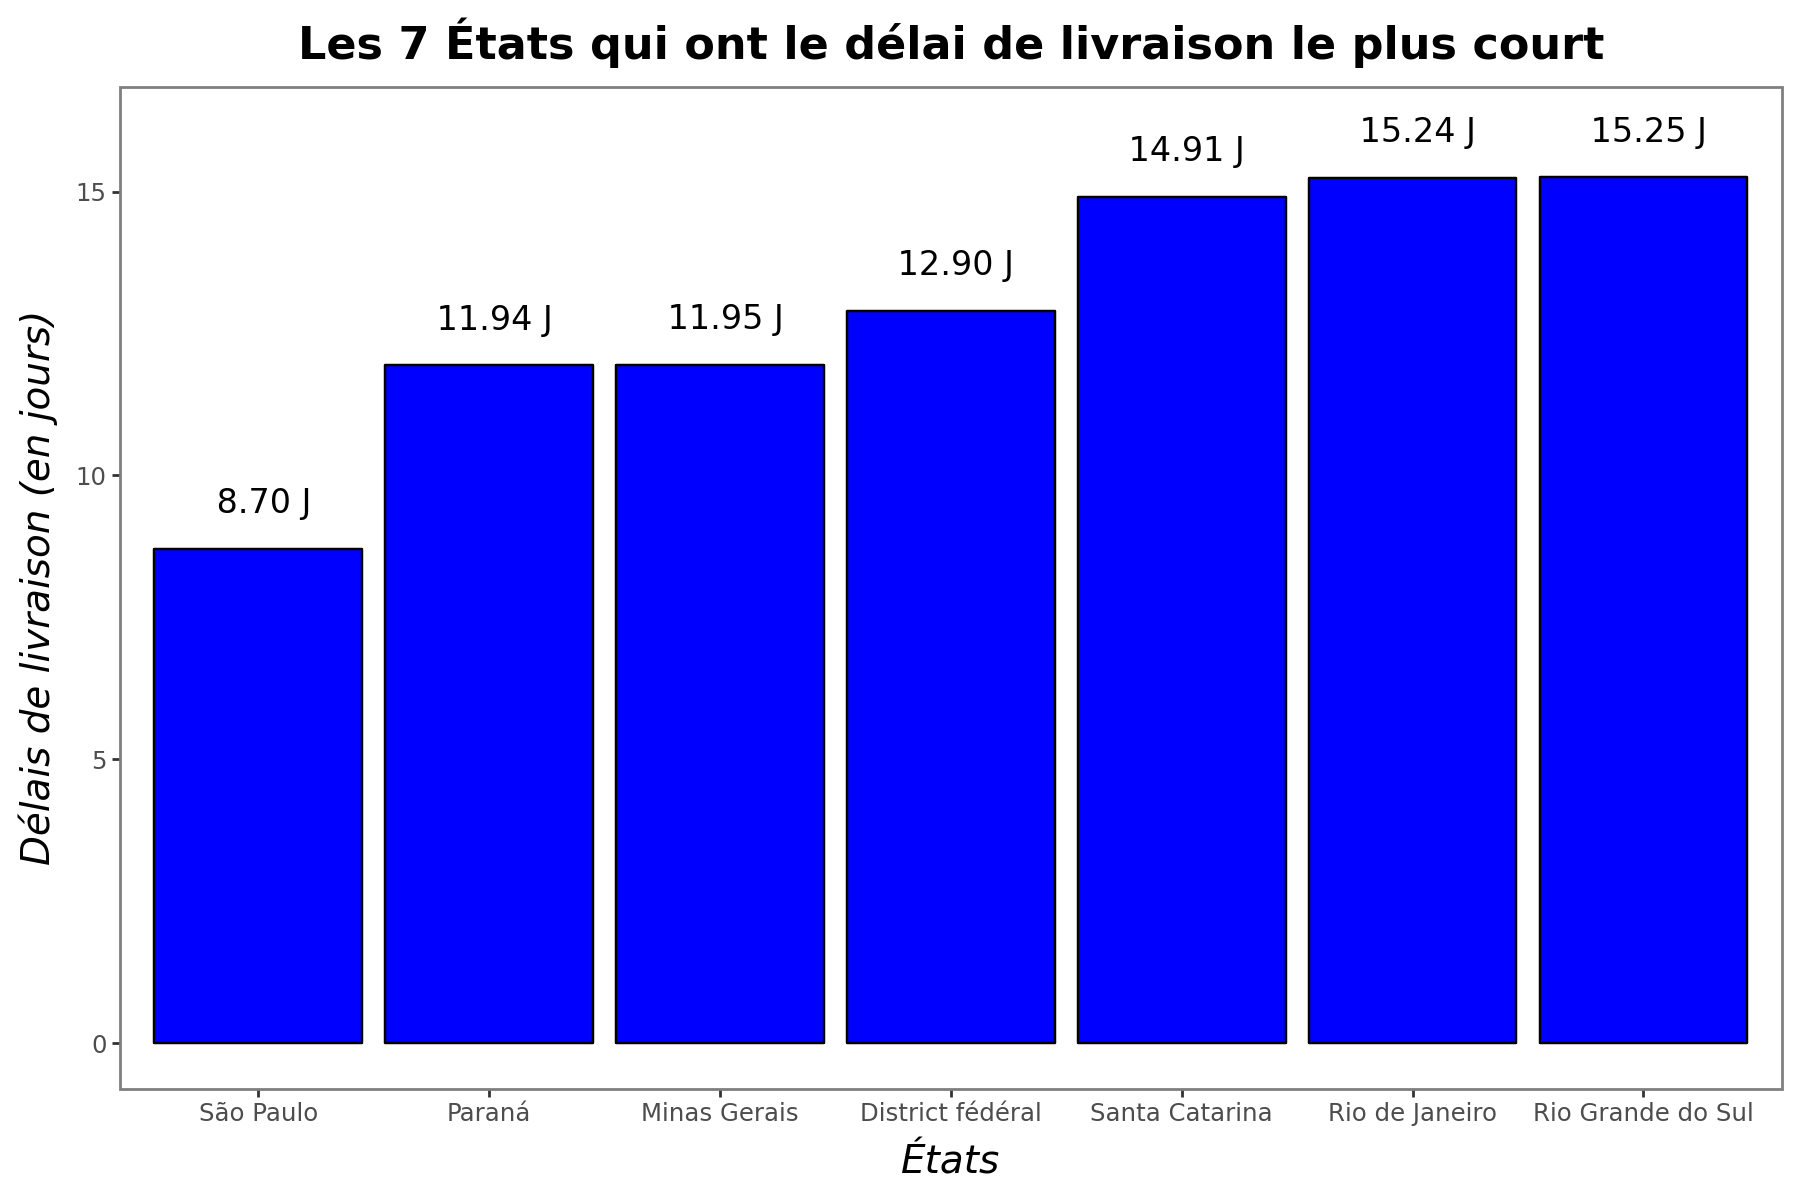

In [225]:
# Visuel graphique
theme_list = list(etats_liv_plus_courte["_id"].iloc[:7]) # Jusqu'au 7 premiers

# Les vrais noms d'états :
theme_list_labels = ["São Paulo", "Paraná", 
                     "Minas Gerais", "District fédéral", "Santa Catarina",
                      "Rio de Janeiro", "Rio Grande do Sul"]

(
plotn.ggplot(etats_liv_plus_courte.iloc[:7], plotn.aes(x="_id", y="avg_delay")) # Jeu de données
    + plotn.geom_bar(stat = "identity",
                   color="black",
                   fill="blue") # Ajout du type de graphique avec couleur des bordures + barres
    + plotn.labs(title="Les 7 États qui ont le délai de livraison le plus court",
               x = "États",
               y = "Délais de livraison (en jours)") # Ajout des titres
    + plotn.geom_text(
        plotn.aes(label = "avg_delay"),
        size = 12,
        nudge_y=0.8,
        format_string="{: .2f} J")
    + plotn.scale_x_discrete(limits=theme_list, labels=theme_list_labels) # Ordre décroissante
    + plotn.theme_bw() # Thème utilisé
    + plotn.theme(figure_size=(9, 6), # Taille de la figure
                panel_grid= plotn.element_blank(),
                plot_title=plotn.element_text(size=16, face='bold'),
                axis_title=plotn.element_text(size=14, face='italic'))
)

## **Catégorie de produit la mieux notée**

### *Requête MongoDB*

In [221]:
# Création du Pipeline sur les différentes jointures à faire et calculer la moyenne des notes par vendeur

# Jointure pour avoir les items
stage_lookup_product_items = {
    "$lookup" : {
        "from" : "olist_order_items_dataset",
        "localField" : "product_id", 
        "foreignField" : "product_id", 
        "as" : "related_items" 
    }
}

# Jointure pour avoir les orders
stage_lookup_order = {
    "$lookup" : {
        "from" : "olist_orders_dataset",
        "localField" : "related_items.order_id", 
        "foreignField" : "order_id", 
        "as" : "related_orders" 
    }
}

stage_lookup_review = {
    "$lookup" : {
        "from" : "olist_order_reviews_dataset",
        "localField" : "related_orders.order_id", 
        "foreignField" : "order_id", 
        "as" : "related_reviews" 
    }
}

# Calcul de la longueur de la liste related_orders pour savoir le nombre de commande
# Calcul de la moyenne des notes dans la liste related_reviews
length_orders_avg_score = {
        '$addFields': {
          'nb_orders': {
            '$size': '$related_orders'
          },
          "avg_review_score" : {
              "$avg" : "$related_reviews.review_score"
          }
        }
      }

# Mettre dans l'ordre décroissante selon le review_score et le nombre de commandes liées
sort_scoring ={
    "$sort" : {
        "avg_review_score" : -1,
        "nb_orders" : -1
    }
} 

# Sélection des colonnes
elts_sellers = {
    "$project" :
    {
        "_id" : 0, 
        "product_id" : 1,
        "product_category_name" : 1, 
        #"related_reviews.review_score" : 1,
        #"related_orders.order_id" : 1,
        "nb_orders" : 1,
        "avg_review_score" : 1
    }
}


# Limiter pour le meilleur produit noté
limit_1_prod = {
    "$limit": 1
}

# Sauvegarder les résultats dans une nouvelle collection
out_sellers = {"$out" : {"db" : "aggregation_resultat", "coll" : "produit_mieux_note"}}

# Création du pipeline
pipeline = [
stage_lookup_product_items,
stage_lookup_order,
stage_lookup_review,
length_orders_avg_score,
elts_sellers,
sort_scoring,
limit_1_prod,
out_sellers
]

In [222]:
# Application du pipeline
results = dict_inst_mongdb["olist_products_dataset"].aggregate(pipeline)

In [223]:
liste_results = list(db_agg["produit_mieux_note"].find())

In [224]:
print(liste_results)

[{'_id': ObjectId('677c4acb1f2881a1b5366c33'), 'product_id': '2722b7e5f68e776d18fe901638034e54', 'product_category_name': 'beleza_saude', 'nb_orders': 13, 'avg_review_score': 5.0}]


#### Commentaire :
On peut observer que c'est la catégorie "beauté santé" (beleza_saude) qui possède la meilleure note et qui a la plus de commande par rapport à ceux qui ont une meilleure note.  